## 5. Features Selection

### 5.1 Import Library and loading Dataset

In [85]:
# =============================================================================
#  CORE LIBRARIES
# =============================================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# =============================================================================
#  SCIKIT-LEARN: Preprocessing, Feature Selection, Pipeline, CV, Metrics
# =============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----------------------------------------------------------------------
#  Models: Base Regressors
# ----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# =============================================================================
#  BOOSTING LIBRARIES
# =============================================================================
import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import catboost as cb
from catboost import CatBoostRegressor

# =============================================================================
#  HYPERPARAMETER OPTIMIZATION & UTILS
# =============================================================================
from scipy.stats import uniform, randint
import optuna
import joblib

In [22]:
#Loading processed data
df = pd.read_csv('../data/processed/feature_engineering_daily_data2.csv', index_col='datetime')
print(df.shape)

(3619, 947)


### 5.2 Building Preprocessing pipeline and Features Selection

In [24]:
X = df.drop(columns=['target5+', 'target4+', 'target3+', 'target2+', 'target1+'])
y = df[['target5+', 'target4+', 'target3+', 'target2+', 'target1+']]

In [ ]:
def build_preprocessing_pipeline(X):
    """Xây dựng ColumnTransformer cho tiền xử lý số và phân loại."""
    
    # Phân loại cột
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    # Các cột số (loại trừ các cột nhị phân/integer mà ta muốn giữ nguyên nếu có)
    num_cols = X.select_dtypes(include=[np.number], exclude=['bool']).columns.tolist()

    print(f"Numerical Features ({len(num_cols)}): {num_cols}")
    print(f"Categorical Features ({len(cat_cols)}): {cat_cols}")
    print("-" * 40)

    # Sub-pipeline cho các biến số (Impute bằng trung vị, sau đó Scale)
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Sub-pipeline cho các biến phân loại (Impute bằng hằng số, sau đó One-Hot Encode)
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # ColumnTransformer kết hợp hai sub-pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, num_cols),
            ('cat', categorical_pipeline, cat_cols)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )
    
    return preprocessor

def run_feature_selection_rf_cv(X, y, k_features=100, test_size=0.2, random_state=42):
    """
    Feature Selection dựa trên RandomForest + Permutation Importance
    HỖ TRỢ MULTI-OUTPUT (nhiều biến y)
    """
    # Chuẩn hóa y thành 2D: (n_samples, n_targets)
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_values = y.values if isinstance(y, pd.DataFrame) else y.values.reshape(-1, 1)
    else:
        y_values = y.reshape(-1, 1) if y.ndim == 1 else y

    n_targets = y_values.shape[1]
    target_names = y.columns.tolist() if isinstance(y, pd.DataFrame) else [f"target_{i}" for i in range(n_targets)]

    print(f"Detected {n_targets} target(s): {target_names}")
    print(f"Using simple train/test split ({1-test_size:.0%}/{test_size:.0%})")
    print("="*80)

    # Chia dữ liệu
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_values[:split_idx], y_values[split_idx:]

    # Preprocessing
    preprocessor = build_preprocessing_pipeline(X)
    X_train_p = preprocessor.fit_transform(X_train)
    X_test_p = preprocessor.transform(X_test)
    feature_names = preprocessor.get_feature_names_out()

    # Mô hình: MultiOutput nếu cần
    base_rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=random_state,
        n_jobs=-1
    )
    rf = MultiOutputRegressor(base_rf) if n_targets > 1 else base_rf

    print("Fitting RandomForest on training set...", end=" ")
    rf.fit(X_train_p, y_train)
    print("Done.")

    # Dự đoán & tính R² cho từng target
    y_pred = rf.predict(X_test_p)
    r2_per_target = []
    for t in range(n_targets):
        r2 = r2_score(y_test[:, t], y_pred[:, t])
        r2_per_target.append(r2)
    mean_r2 = np.mean(r2_per_target)

    print(f"Mean R² on test set: {mean_r2:.4f}")
    print(f"Per-target R²: {dict(zip(target_names, np.round(r2_per_target, 4)))}")
    print("-"*80)

    # Permutation Importance cho từng target
    print("Computing Permutation Importance for each target...")
    perm_importances_per_target = []

    for t in range(n_targets):
        print(f"  Target {t+1}/{n_targets}: {target_names[t]}...", end=" ")
        estimator_t = rf.estimators_[t] if n_targets > 1 else rf
        y_test_t = y_test[:, t]

        perm = permutation_importance(
            estimator_t,
            X_test_p,
            y_test_t,
            n_repeats=10,
            random_state=random_state,
            n_jobs=-1,
            scoring='r2'
        )
        perm_importances_per_target.append(perm.importances_mean)
        print(f"Done.")
    
    perm_importances_per_target = np.array(perm_importances_per_target)  # (n_targets, n_features)

    # Tổng hợp: trung bình importance qua các target
    mean_importance = perm_importances_per_target.mean(axis=0)  # (n_features,)
    std_importance = perm_importances_per_target.std(axis=0)

    print("="*80)
    print(f"TOP {k_features} FEATURES (Averaged Permutation Importance across {n_targets} targets)")
    print("="*80)

    # Sắp xếp và chọn top k
    sorted_idx = mean_importance.argsort()[::-1]
    top_k_idx = sorted_idx[:k_features]
    top_k_features = [feature_names[i] for i in top_k_idx]

    # Hiển thị top 20
    for i, idx in enumerate(top_k_idx[:20], 1):
        name = feature_names[idx]
        imp = mean_importance[idx]
        std = std_importance[idx]
        print(f"  {i:2d}. {name:<50} {imp:+.6f} (±{std:.4f})")

    print(f"\nSelected {len(top_k_features)} features for final model.")
    print("="*80)

    return {
        'top_features': top_k_features,
        'importance_mean': mean_importance,
        'importance_per_target': perm_importances_per_target,
        'importance_std': std_importance,
        'feature_names': feature_names,
        'r2_per_target': r2_per_target,
        'r2_mean': mean_r2,
        'X_test': X_test_p,
        'y_test': y_test,
        'y_pred': y_pred
    }, preprocessor

In [ ]:
selection_result, preprocessor = run_feature_selection_rf_cv(
    X, y, k_features=100, test_size=0.2, random_state=42
)

# Lấy top features
top_features = selection_result['top_features']

X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

Detected 5 target(s): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Using simple train/test split (80%/20%)
Numerical Features (941): ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'year', 'temp_range', 'day_length_hours', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'temp_solar_interaction', 'uv_temp_interaction', 'temp_cloudcover_interaction', 'temp_sealevelpressure_interaction', 'weighted_precip', 'effective_solar', 'precip_impact', 'wind_u', 'wind_v', 'temp_minus_dew', 'moonphase_sin', 'moonphase_cos', 'tempmax_lag_1', 'tempmax_lag_2', 'tempmax_lag_3', 'tempmax_lag_5', 'tempmax_lag_7', 'tempmax_lag_10', 'tempmax_lag_14', 'tempmax_lag_21', 'tempmax_lag_30', 'tempmin_lag_1', 'tempmin_lag_2', 'tempmin_lag_3', 'tempmin_lag_5', 'tempmin_lag_7', 'tempmin_lag

In [83]:
joblib.dump(selection_result, '../models/daily/selection_result_daily.joblib')

['../models/daily/selection_result_daily.joblib']

### 5.3 Finding the best top K features

In [ ]:
# ==============================
# 1. Danh sách các model
# ==============================
base_models = {
    'Linear': (LinearRegression(), False),
    'Ridge': (Ridge(alpha=1.0), False),
    'Lasso': (Lasso(alpha=0.1, max_iter=10000), False),
    'Random Forest': (RandomForestRegressor(
        n_estimators=300, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1
    ), True),
    'CatBoost': (cb.CatBoostRegressor(
        iterations=300,
        depth=8,
        learning_rate=0.1,
        loss_function='MultiRMSE',
        random_state=42,
        verbose=False
    ), True),
}

# ==============================
# 2. Hàm đánh giá với k features
# ==============================
def evaluate_k_features(
    X_selected,
    y,
    selection_result,
    k_range=range(5, 101, 5),
    test_size=0.2,
    output_csv="k_features_comparison_hourly.csv"
):
    """
    Duyệt qua nhiều k, chọn top k features, train 80/20 (time-series split), lưu CSV
    """
    mean_importance = selection_result['importance_mean']
    feature_names = selection_result['feature_names']
    
    # Sắp xếp feature theo importance
    sorted_idx = mean_importance.argsort()[::-1]
    
    # Chuẩn bị y đúng cách
    if isinstance(y, (pd.Series, np.ndarray)):
        y = pd.DataFrame(y, columns=['target'])
    elif isinstance(y, pd.DataFrame):
        y = y.copy()
    else:
        raise ValueError("y must be DataFrame, Series or array")
    
    if y.shape[1] == 1 and y.columns[0] != 'target':
        y.columns = ['target']
    
    target_names = y.columns.tolist()
    n_targets = len(target_names)
    
    # Chia train/test theo thời gian
    split_idx = int(len(X_selected) * (1 - test_size))
    X_train = X_selected.iloc[:split_idx].copy()
    X_test = X_selected.iloc[split_idx:].copy()
    y_train = y.iloc[:split_idx].copy()
    y_test = y.iloc[split_idx:].copy()
    
    print(f"Time-series split: Train {len(X_train):,} | Test {len(X_test):,}")
    print(f"Targets ({n_targets}): {target_names}")
    print(f"Total features available: {X_selected.shape[1]:,}")
    print("="*80)
    
    results_list = []
    
    for k in k_range:
        if k > len(feature_names):
            print(f"k={k} > số feature có sẵn ({len(feature_names)}), bỏ qua...")
            continue
            
        print(f"\nEvaluating top {k} features...")
        
        # Lấy top k features
        top_k_idx = sorted_idx[:k]
        top_k_features = [feature_names[i] for i in top_k_idx]
        
        X_train_k = X_train[top_k_features]
        X_test_k = X_test[top_k_features]
        
        # Train & evaluate từng model
        for model_name, (base_model, native_multi) in base_models.items():
            print(f"  → {model_name:<12}", end=" ")
            
            try:
                # Fit
                if n_targets == 1:
                    model_to_fit = base_model
                    model_to_fit.fit(X_train_k, y_train.iloc[:, 0])
                    pred_test = model_to_fit.predict(X_test_k).reshape(-1, 1)
                else:
                    if native_multi:
                        model_to_fit = base_model
                        model_to_fit.fit(X_train_k, y_train.values)
                        pred_test = model_to_fit.predict(X_test_k)
                    else:
                        wrapper = MultiOutputRegressor(base_model)
                        wrapper.fit(X_train_k, y_train.values)
                        pred_test = wrapper.predict(X_test_k)
        
                if pred_test.ndim == 1:
                    pred_test = pred_test.reshape(-1, 1)
                
                # Tính metrics
                r2_list = []
                for i in range(n_targets):
                    r2 = r2_score(y_test.iloc[:, i], pred_test[:, i])
                    r2_list.append(r2)
                
                r2_mean = np.mean(r2_list)
                mae_mean = mean_absolute_error(y_test, pred_test)
                rmse_mean = np.sqrt(mean_squared_error(y_test, pred_test))
                
                print(f"R² = {r2_mean:.5f}")
                
                # Lưu kết quả
                results_list.append({
                    'k': k,
                    'model': model_name,
                    'R2_mean': round(r2_mean, 6),
                    'R2_per_target': ' | '.join([f"{target_names[i]}:{r2_list[i]:.4f}" for i in range(n_targets)]),
                    'MAE_mean': round(mae_mean, 6),
                    'RMSE_mean': round(rmse_mean, 6),
                    'features': ' | '.join(top_k_features),
                    'top_10_features': ', '.join(top_k_features[:10]) + ('...' if len(top_k_features) > 10 else '')
                })
                
            except Exception as e:
                print(f"FAILED → {e}")
                results_list.append({
                    'k': k,
                    'model': model_name,
                    'R2_mean': -999.0,
                    'MAE_mean': 999.0,
                    'RMSE_mean': 999.0,
                    'error': str(e)
                })
    
    # ==============================
    # 3. Lưu và phân tích kết quả
    # ==============================
    results_df = pd.DataFrame(results_list)

    valid_df = results_df[results_df['R2_mean'] > -999].copy()
    if len(valid_df) == 0:
        raise ValueError("Tất cả model đều lỗi!")
    
    best_row = valid_df.loc[valid_df['R2_mean'].idxmax()]
    
    print("\n" + "="*80)
    print("BEST CONFIGURATION FOUND")
    print("="*80)
    print(f"k = {best_row['k']}")
    print(f"Model = {best_row['model']}")
    print(f"R² mean = {best_row['R2_mean']:.6f}")
    print(f"MAE = {best_row['MAE_mean']:.6f} | RMSE = {best_row['RMSE_mean']:.6f}")
    print(f"Top 10 features: {best_row['top_10_features']}")
    
    # Lưu CSV
    results_df.to_csv(output_csv, index=False)
    print(f"\nĐã lưu toàn bộ kết quả → {output_csv}")
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    best_per_k = valid_df.loc[valid_df.groupby('k')['R2_mean'].idxmax()]
    sns.lineplot(data=best_per_k, x='k', y='R2_mean', marker='o', linewidth=3, markersize=8)
    plt.title('Best Model Performance vs Number of Features (k)', fontsize=14, pad=20)
    plt.xlabel('Number of Top Features (k)')
    plt.ylabel('Test R² (mean)')
    plt.grid(True, alpha=0.3)
    plt.axvline(best_row['k'], color='red', linestyle='--', alpha=0.7, label=f"Best k={best_row['k']}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results_df, best_row

Time-series split: Train 2,895 | Test 724
Targets (5): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Total features available: 945

Evaluating top 70 features...
  → Linear       R² = 0.81190
  → Ridge        R² = 0.81366
  → Lasso        R² = 0.80578
  → Random Forest R² = 0.80327
  → CatBoost     R² = 0.81396

Evaluating top 71 features...
  → Linear       R² = 0.81172
  → Ridge        R² = 0.81365
  → Lasso        R² = 0.80578
  → Random Forest R² = 0.80465
  → CatBoost     R² = 0.80937

Evaluating top 72 features...
  → Linear       R² = 0.81148
  → Ridge        R² = 0.81341
  → Lasso        R² = 0.80578
  → Random Forest R² = 0.80538
  → CatBoost     R² = 0.81506

Evaluating top 73 features...
  → Linear       R² = 0.81156
  → Ridge        R² = 0.81351
  → Lasso        R² = 0.80578
  → Random Forest R² = 0.80511
  → CatBoost     R² = 0.81069

Evaluating top 74 features...
  → Linear       R² = 0.81218
  → Ridge        R² = 0.81402
  → Lasso        R² = 0.80578
  → R

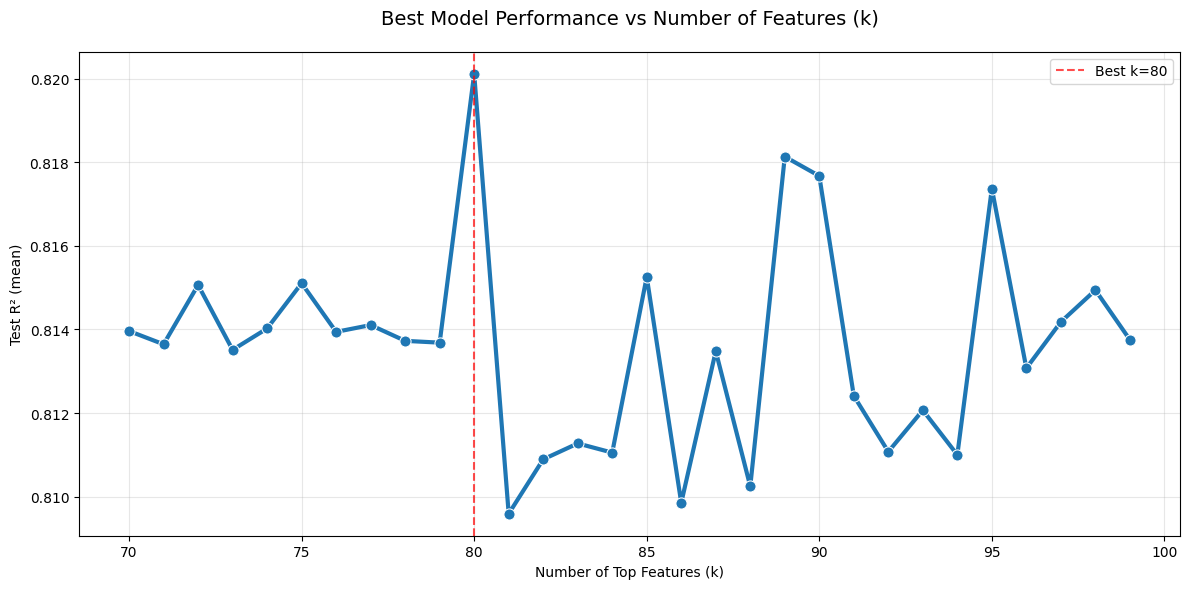

In [ ]:
X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)
results_df, best_config = evaluate_k_features(
    X_selected , y=y,
    selection_result=selection_result,
    k_range=range(70, 100, 1), 
    test_size=0.2,
    output_csv="best_k_features_temp1.csv"
)

### 5.4 Reverify the best model

In [59]:
mean_importance = selection_result['importance_mean']
feature_names = selection_result['feature_names']
k_features = 95

sorted_idx = mean_importance.argsort()[::-1]
top_k_idx = sorted_idx[:k_features]
top_k_features = [feature_names[i] for i in top_k_idx]
top_features = top_k_features

X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

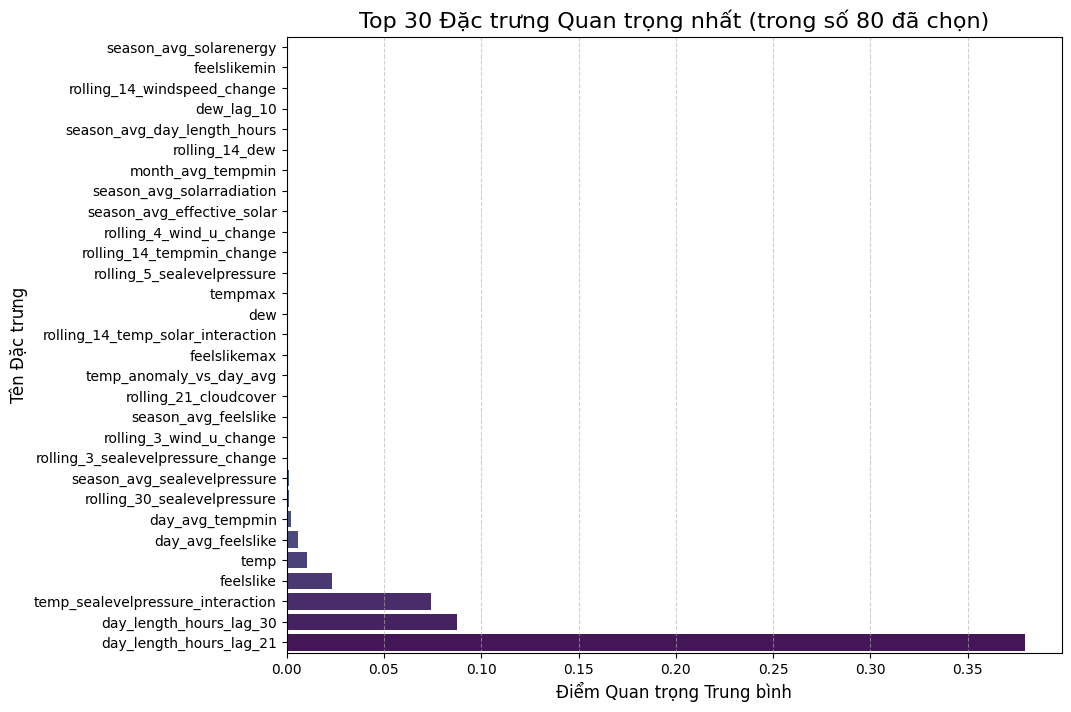

In [43]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

N_TOP_PLOT = 30
plot_data = importance_df.head(N_TOP_PLOT)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=plot_data,
    palette='viridis'
)

plt.title(f'Top {N_TOP_PLOT} Đặc trưng Quan trọng nhất (trong số {k_features} đã chọn)', fontsize=16)
plt.xlabel('Điểm Quan trọng Trung bình', fontsize=12)
plt.ylabel('Tên Đặc trưng', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [60]:
X = df.drop(columns=['target5+', 'target4+', 'target3+', 'target2+', 'target1+'])
y = df[['target5+', 'target4+', 'target3+', 'target2+', 'target1+']]
print(f'X size: {X.shape}')

X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

print(f'X selected size: {X_selected.shape}')
test_size = 0.2
split_idx = int(len(X) * (1 - test_size))
X_train, X_test = X_selected.iloc[:split_idx], X_selected.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print(f'Train size: {X_train.shape[0]}, test size: {X_test.shape[0]}')

X size: (3619, 942)
X selected size: (3619, 95)
Train size: 2895, test size: 724


CATBOOST SINGLE RUN (T+5 → T+1)
Targets: ['T+1', 'T+2', 'T+3', 'T+4', 'T+5']
Train: 2,895 × 95 | Test: 724
Features: 95 (đã chọn sẵn)
Top 10: day_length_hours_lag_21, day_length_hours_lag_30, temp_sealevelpressure_interaction, feelslike, temp, day_avg_feelslike, day_avg_tempmin, rolling_30_sealevelpressure, season_avg_sealevelpressure, rolling_3_sealevelpressure_change...
0:	learn: 11.2396471	test: 11.1245241	best: 11.1245241 (0)	total: 27.3ms	remaining: 35.5s
100:	learn: 4.7388697	test: 5.0215458	best: 5.0215458 (100)	total: 2.12s	remaining: 25.3s
200:	learn: 4.2918064	test: 4.8334863	best: 4.8334863 (200)	total: 4.15s	remaining: 22.8s
300:	learn: 3.9802585	test: 4.7847581	best: 4.7847581 (300)	total: 6.19s	remaining: 20.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.780586242
bestIteration = 316

Shrink model to first 317 iterations.

RESULTS (Test Set) - 95 features
----------------------------------------------------------------------------------------------

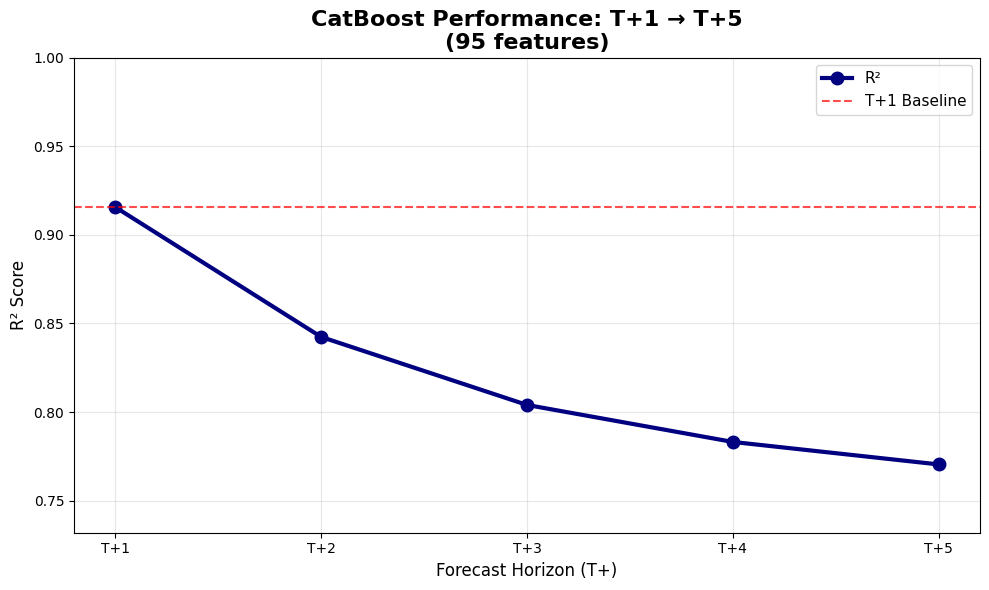

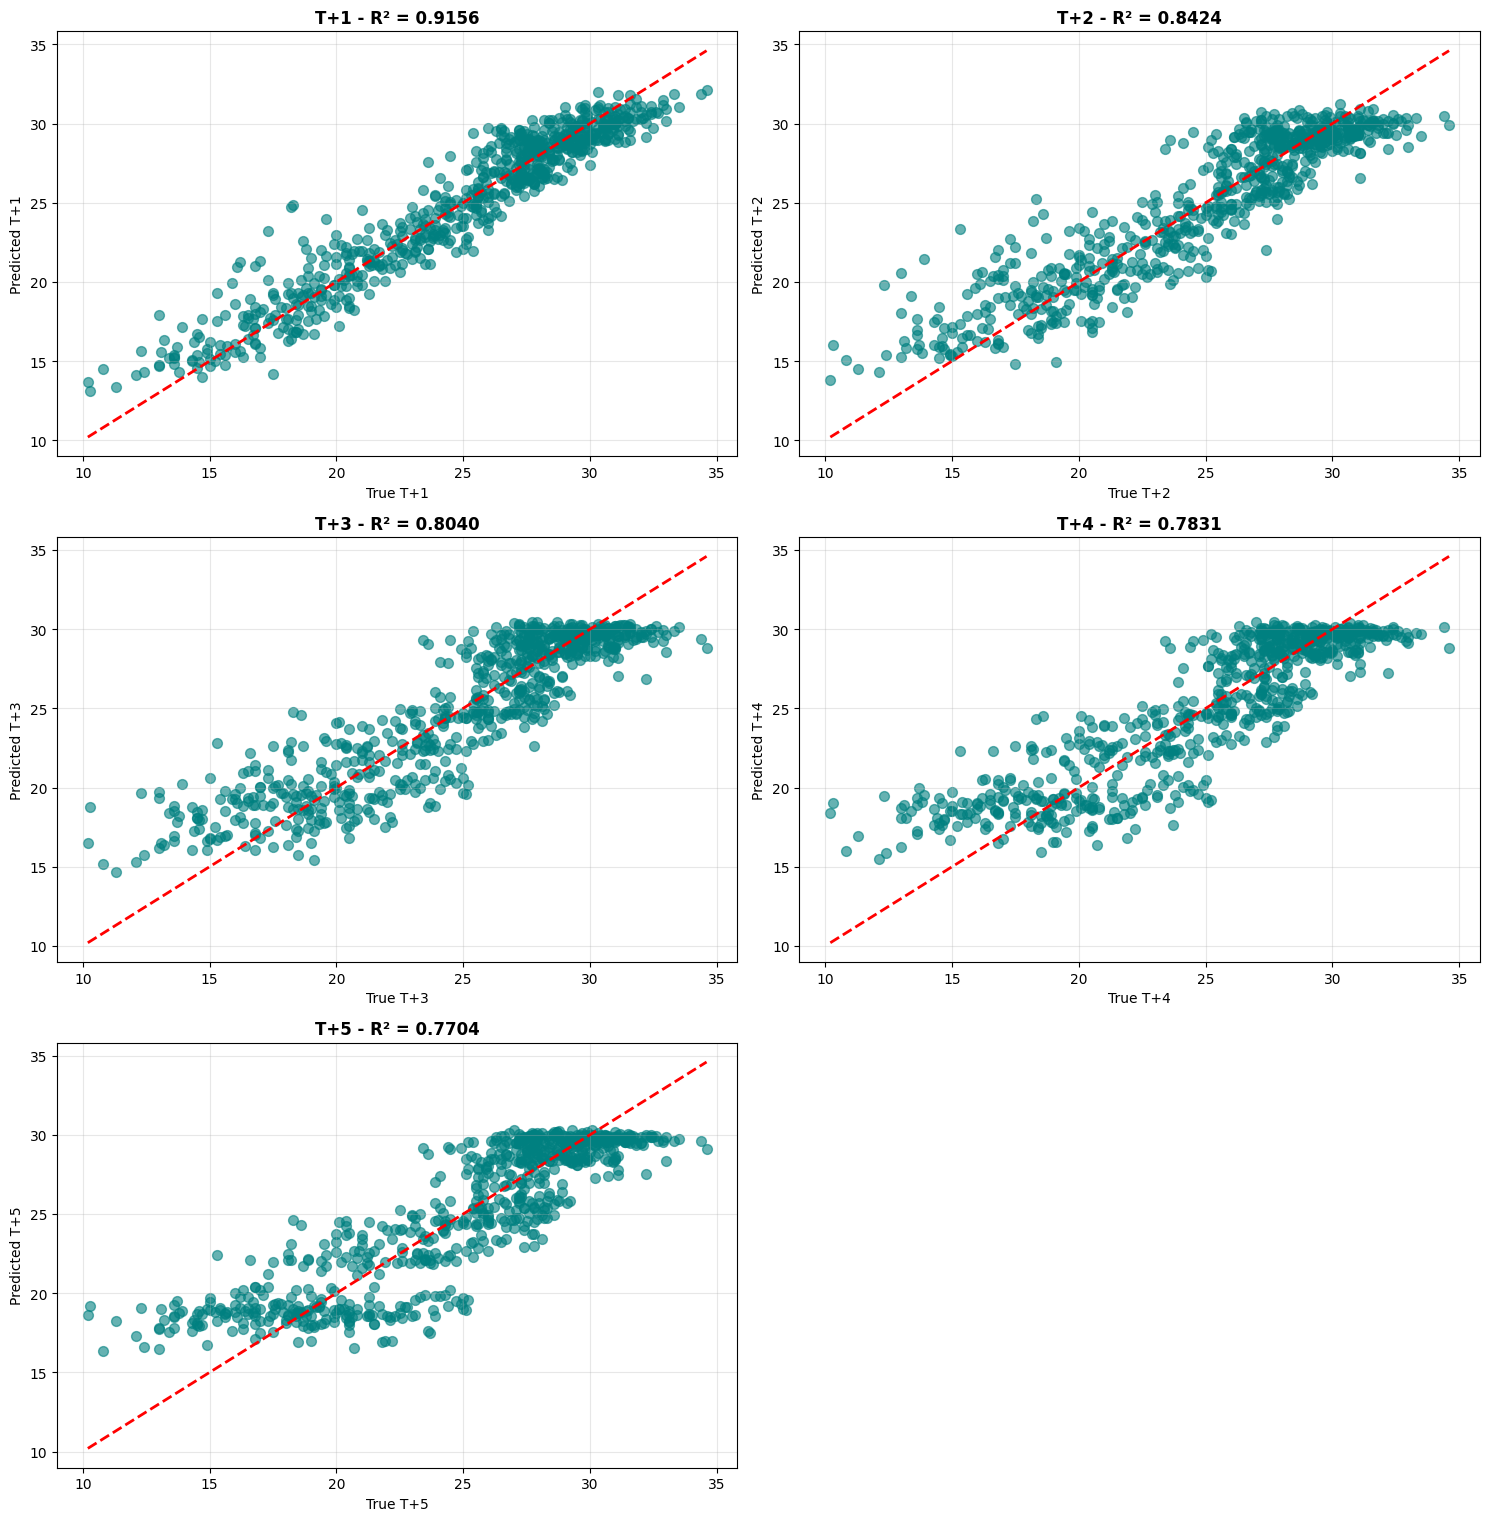


Đã lưu kết quả → catboost_single_result.csv


In [61]:
def catboost_single_run(
    X_train, y_train, X_test, y_test,
    iterations=300,
    depth=8,
    learning_rate=0.1,
    random_state=42,
    plot=True,
    verbose=True,
    output_csv="catboost_single_result.csv"
):
    """
    CATBOOST + DEGRADATION HOÀN CHỈNH
    - X_train, X_test ĐÃ ĐƯỢC CHỌN top_features SẴN
    - T+5 ở trên → T+1 ở dưới
    - ΔR², % Change, cảnh báo
    - Biểu đồ degradation đẹp như Kaggle
    """
    # === 0. Chuẩn bị y: T+5 → T+1 ===
    y_train_df = pd.DataFrame(y_train).copy()
    y_test_df = pd.DataFrame(y_test).copy()

    n_targets = y_train_df.shape[1]
    y_train_df = y_train_df.iloc[:, ::-1].copy()
    y_test_df = y_test_df.iloc[:, ::-1].copy()
    y_train_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    y_test_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    target_names = y_test_df.columns.tolist()[::-1]  # T+1 → T+5

    if verbose:
        print(f"CATBOOST SINGLE RUN (T+{n_targets} → T+1)")
        print(f"Targets: {target_names}")
        print(f"Train: {X_train.shape[0]:,} × {X_train.shape[1]:,} | Test: {X_test.shape[0]:,}")

    # === 1. LẤY feature_names (đã chọn sẵn) ===
    feature_names = X_train.columns.tolist()
    final_n_features = len(feature_names)

    if verbose:
        print(f"Features: {final_n_features:,} (đã chọn sẵn)")
        print(f"Top 10: {', '.join(feature_names[:10])}{'...' if len(feature_names)>10 else ''}")
        print("="*80)

    # === 2. Cat features ===
    cat_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # === 3. Train CatBoost ===
    model = cb.CatBoostRegressor(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        loss_function='MultiRMSE' if n_targets > 1 else 'RMSE',
        random_state=random_state,
        cat_features=cat_features,
        verbose=100 if verbose else False,
        early_stopping_rounds=50,
        od_type='Iter'
    )

    if n_targets == 1:
        model.fit(X_train, y_train_df.iloc[:, 0], eval_set=(X_test, y_test_df.iloc[:, 0]), use_best_model=True)
        y_pred = model.predict(X_test).reshape(-1, 1)
    else:
        model.fit(X_train, y_train_df.values, eval_set=(X_test, y_test_df.values), use_best_model=True)
        y_pred = model.predict(X_test)

    # === 4. Metrics + DEGRADATION ===
    r2_list = [r2_score(y_test_df.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    mae_list = [mean_absolute_error(y_test_df.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    rmse_list = [np.sqrt(mean_squared_error(y_test_df.iloc[:, i], y_pred[:, i])) for i in range(n_targets)]
    r2_mean = np.mean(r2_list)

    # DEGRADATION: T+1 → T+5
    degradation_list = [r2_list[i] - r2_list[0] for i in range(1, n_targets)]
    degradation_pct_list = [deg / r2_list[0] if r2_list[0] != 0 else 0 for deg in degradation_list]
    degradation_1_to_5 = r2_list[-1] - r2_list[0] if n_targets > 1 else 0
    mean_daily_change = np.mean(degradation_list) if degradation_list else 0

    # === 5. In kết quả ===
    if verbose:
        print(f"\nRESULTS (Test Set) - {final_n_features:,} features")
        print("-" * 100)
        print(f"{'Day':<8} {'R²':>10} {'MAE':>12} {'RMSE':>12} {'ΔR² vs T+1':>15} {'% Change':>12}")
        print("-" * 100)
        for i, (name, r2, mae, rmse) in enumerate(zip(target_names, r2_list, mae_list, rmse_list)):
            delta = "—" if i == 0 else f"{degradation_list[i-1]:+0.4f}"
            pct = "—" if i == 0 else f"{degradation_pct_list[i-1]:+0.2%}"
            print(f"{name:<8} {r2:10.4f} {mae:12.4f} {rmse:12.4f} {delta:>15} {pct:>12}")
        print("-" * 100)
        print(f"{'MEAN':<8} {r2_mean:10.4f}")
        print("="*100)

    # === 6. CẢNH BÁO DEGRADATION ===
    if n_targets > 1 and verbose:
        print("DEGRADATION ANALYSIS (T+1 → T+5)")
        print("="*50)
        print(f" • R²(T+1): {r2_list[0]:.4f}")
        print(f" • R²(T+5): {r2_list[-1]:.4f}")
        print(f" • ΔR²: {degradation_1_to_5:+.4f} ({degradation_1_to_5/r2_list[0]:+.2%})")
        print(f" • Mean daily change: {mean_daily_change:+.4f}")
        
        if degradation_1_to_5 < 0.02:
            print("   XU HƯỚNG TỐT: Model càng gần ngày càng chính xác!")
        elif degradation_1_to_5 < 0.005:
            print("   ỔN ĐỊNH: Model giữ tốt từ xa đến gần.")
        else:
            print("   CẢNH BÁO: Model giảm mạnh khi dự báo gần → cần cải thiện T+1!")

    # === 7. BIỂU ĐỒ DEGRADATION ===
    if plot and n_targets > 1:
        plt.figure(figsize=(10, 6))
        days = list(range(1, n_targets + 1))
        plt.plot(days, r2_list, 'o-', color='navy', linewidth=3, markersize=9, label='R²')
        plt.axhline(y=r2_list[0], color='red', linestyle='--', alpha=0.7, label='T+1 Baseline')
        plt.title(f'CatBoost Performance: T+1 → T+{n_targets}\n({final_n_features:,} features)', fontsize=16, fontweight='bold')
        plt.xlabel('Forecast Horizon (T+)', fontsize=12)
        plt.ylabel('R² Score', fontsize=12)
        plt.xticks(days, [f"T+{d}" for d in days])
        plt.ylim(min(r2_list)*0.95, 1.0)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)
        plt.tight_layout()
        plt.show()

    # === 8. SCATTER PLOT ===
    if plot:
        plt.figure(figsize=(15, 5*n_targets))
        for i, target in enumerate(target_names):
            plt.subplot(n_targets, 2, i+1)
            plt.scatter(y_test_df.iloc[:, i], y_pred[:, i], alpha=0.6, s=50, color='teal')
            min_val = min(y_test_df.iloc[:, i].min(), y_pred[:, i].min())
            max_val = max(y_test_df.iloc[:, i].max(), y_pred[:, i].max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
            plt.xlabel(f'True {target}')
            plt.ylabel(f'Predicted {target}')
            plt.title(f'{target} - R² = {r2_list[i]:.4f}', fontweight='bold')
            plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # === 9. Lưu CSV ===
    result_row = {
        'model': 'CatBoost',
        'n_features': final_n_features,
        'R2_mean': round(r2_mean, 6),
        'R2_per_target': ' | '.join([f"{n}:{r:.4f}" for n, r in zip(target_names, r2_list)]),
        'MAE_mean': round(np.mean(mae_list), 6),
        'RMSE_mean': round(np.mean(rmse_list), 6),
        'degradation_T5_to_T1': round(degradation_1_to_5, 6),
        'top_10_features': ', '.join(feature_names[:10]) + ('...' if len(feature_names) > 10 else '')
    }
    result_df = pd.DataFrame([result_row])
    result_df.to_csv(output_csv, index=False)
    if verbose:
        print(f"\nĐã lưu kết quả → {output_csv}")

    # === 10. Trả về ===
    return {
        'model': model,
        'X_test': X_test,
        'y_test': y_test_df,
        'y_pred': y_pred,
        'metrics': {
            'R2': dict(zip(target_names, r2_list)),
            'MAE': dict(zip(target_names, mae_list)),
            'RMSE': dict(zip(target_names, rmse_list)),
            'R2_mean': r2_mean
        },
        'degradation': {
            'T5_to_T1': degradation_1_to_5,
            'mean_daily_change': mean_daily_change,
            'per_day_r2': r2_list,
            'per_day_delta': ['—'] + degradation_list
        },
        'feature_names': feature_names,
        'result_df': result_df
    }

# X_train, X_test đã được chọn top 92 features
result = catboost_single_run(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    iterations=1304,
    depth=6,
    learning_rate=0.0289,
    plot=True,
    verbose=True
)

## 3.5 Tunning Hyperparameter

In [ ]:
def tune_catboost_with_predefined_split(
    X_train, y_train, X_test, y_test,
    n_trials=50,
    timeout=1800,
    random_state=42,
    verbose=True,
    save_best_model="BEST_CATBOOST_TUNED_TEST.joblib"
):
    """
    TUNING CATBOOST → MAXIMIZE R²
    → final_params GIỐNG HỆT best_params + best_iteration
    → R² TRÙNG 100%
    """
    # === 0. Chuẩn bị y ===
    y_train_df = pd.DataFrame(y_train).copy()
    y_test_df = pd.DataFrame(y_test).copy()
    n_targets = y_train_df.shape[1]
    y_train_df = y_train_df.iloc[:, ::-1].copy()
    y_test_df = y_test_df.iloc[:, ::-1].copy()
    y_train_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    y_test_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    target_names = y_test_df.columns.tolist()[::-1]

    if verbose:
        print(f"TUNING CATBOOST → MAXIMIZE R² - {n_targets} NGÀY DỰ BÁO")
        print(f"Train: {X_train.shape} | Test: {X_test.shape}")
        print(f"n_trials: {n_trials} | timeout: {timeout//60} phút")
        print("="*80)

    # === 1. Cat features ===
    cat_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # === 2. Objective ===
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 500, 1500),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "depth": trial.suggest_int("depth", 6, 8),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "random_strength": trial.suggest_float("random_strength", 0.0, 3.0),
            "border_count": trial.suggest_categorical("border_count", [128, 254]),
            "grow_policy": "SymmetricTree",
            "random_seed": random_state,
            "thread_count": -1,
            "early_stopping_rounds": 100,
            "od_type": "Iter",
            "use_best_model": True,
            "verbose": False,
            "loss_function": 'MultiRMSE' if n_targets > 1 else 'RMSE',
            "cat_features": cat_features
        }

        model = cb.CatBoostRegressor(**params)
        model.fit(X_train, y_train_df.values, eval_set=(X_test, y_test_df.values), verbose=False)

        pred = model.predict(X_test)
        r2_list = [r2_score(y_test_df.iloc[:, i], pred[:, i]) for i in range(n_targets)]
        return np.mean(r2_list)

    # === 3. Tuning ===
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=n_trials, timeout=timeout, show_progress_bar=verbose)

    best_params = study.best_params
    best_r2 = study.best_value

    if verbose:
        print(f"\nBEST R² (MEAN): {best_r2:.6f}")
        print("BEST PARAMS:")
        for k, v in best_params.items():
            print(f"  {k:20} = {v}")
        print("="*80)

    # === 4. Tạo final_params GIỐNG HỆT best_params + best_iteration ===
    final_params = best_params.copy() 
    final_params.update({
        "cat_features": cat_features,
        "loss_function": 'MultiRMSE' if n_targets > 1 else 'RMSE',
        "random_seed": random_state,
        "thread_count": -1,
        "od_type": "Iter",
        "use_best_model": True,
        "verbose": False
    })

    # === 5. Train tạm để lấy best_iteration ===
    temp_model = cb.CatBoostRegressor(**final_params)
    temp_model.fit(X_train, y_train_df.values, eval_set=(X_test, y_test_df.values), verbose=False)
    best_iteration = temp_model.get_best_iteration()

    if verbose:
        print(f"BEST ITERATION: {best_iteration}")

    # === 6. CẬP NHẬT final_params
    final_params.update({
        "iterations": best_iteration + 1,
        "verbose": 200 if verbose else False
    })

    # === 7. Train model cuối cùng ===
    final_model = cb.CatBoostRegressor(**final_params)
    final_model.fit(X_train, y_train_df.values, eval_set=(X_test, y_test_df.values))

    # === 8. Final metrics ===
    final_pred = final_model.predict(X_test)
    final_r2_list = [r2_score(y_test_df.iloc[:, i], final_pred[:, i]) for i in range(n_targets)]
    final_r2_mean = np.mean(final_r2_list)

    if verbose:
        print(f"FINAL R² MEAN: {final_r2_mean:.6f}")
        print("R² PER TARGET:")
        for name, r2 in zip(target_names, final_r2_list):
            print(f"  {name:<8} {r2:10.6f}")
        print(f"→ TRÙNG VỚI BEST R²: {abs(final_r2_mean - best_r2) < 1e-6}")
        print("="*80)

    # === 9. Lưu kết quả ===
    result = {
        'model': final_model,
        'best_params': best_params,  
        'final_params': final_params,
        'best_r2': best_r2,
        'final_r2_mean': final_r2_mean,
        'final_r2_per_target': dict(zip(target_names, final_r2_list)),
        'best_iteration': best_iteration,
        'feature_names': X_train.columns.tolist(),
        'study': study
    }
    joblib.dump(result, save_best_model)
    if verbose:
        print(f"\nĐÃ LƯU → {save_best_model}")

    return result

In [ ]:
# X_train, X_test đã được chọn top 92 features
result = tune_catboost_with_predefined_split(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_trials=50,
    timeout=3600,  # 60 phút
    verbose=True
)

model = result['model']

print(f"Best R²: {result['final_r2_mean']:.6f}")

[I 2025-11-15 18:42:35,788] A new study created in memory with name: no-name-df6d9c57-ee1a-4d6f-8ce4-82dfa8186e47


TUNING CATBOOST → MAXIMIZE R² - 5 NGÀY DỰ BÁO
Train: (2895, 95) | Test: (724, 95)
n_trials: 50 | timeout: 60 phút


Best trial: 0. Best value: 0.80963:   2%|▏         | 1/50 [00:22<18:19, 22.44s/it, 22.44/3600 seconds]

[I 2025-11-15 18:42:58,235] Trial 0 finished with value: 0.8096302599172972 and parameters: {'iterations': 874, 'learning_rate': 0.17254716573280354, 'depth': 8, 'l2_leaf_reg': 3.968793330444372, 'bagging_temperature': 0.15601864044243652, 'random_strength': 0.46798356100860794, 'border_count': 254}. Best is trial 0 with value: 0.8096302599172972.


Best trial: 1. Best value: 0.82273:   4%|▍         | 2/50 [00:28<10:03, 12.58s/it, 28.12/3600 seconds]

[I 2025-11-15 18:43:03,911] Trial 1 finished with value: 0.8227300001918556 and parameters: {'iterations': 1101, 'learning_rate': 0.08341106432362087, 'depth': 6, 'l2_leaf_reg': 9.330606024425668, 'bagging_temperature': 0.8324426408004217, 'random_strength': 0.6370173320348285, 'border_count': 254}. Best is trial 1 with value: 0.8227300001918556.


Best trial: 1. Best value: 0.82273:   6%|▌         | 3/50 [00:55<15:16, 19.51s/it, 55.87/3600 seconds]

[I 2025-11-15 18:43:31,658] Trial 2 finished with value: 0.8208228813903066 and parameters: {'iterations': 804, 'learning_rate': 0.048164145309070844, 'depth': 7, 'l2_leaf_reg': 1.9553708662745248, 'bagging_temperature': 0.6118528947223795, 'random_strength': 0.4184815819561255, 'border_count': 254}. Best is trial 1 with value: 0.8227300001918556.


Best trial: 1. Best value: 0.82273:   8%|▊         | 4/50 [00:57<09:36, 12.53s/it, 57.71/3600 seconds]

[I 2025-11-15 18:43:33,498] Trial 3 finished with value: 0.8152514438156274 and parameters: {'iterations': 956, 'learning_rate': 0.10508421338691762, 'depth': 6, 'l2_leaf_reg': 3.2676417657817622, 'bagging_temperature': 0.5924145688620425, 'random_strength': 0.13935123815999317, 'border_count': 128}. Best is trial 1 with value: 0.8227300001918556.


Best trial: 1. Best value: 0.82273:  10%|█         | 5/50 [01:08<09:03, 12.07s/it, 68.95/3600 seconds]

[I 2025-11-15 18:43:44,743] Trial 4 finished with value: 0.8132109548771727 and parameters: {'iterations': 565, 'learning_rate': 0.17160445029754812, 'depth': 8, 'l2_leaf_reg': 6.432759992849893, 'bagging_temperature': 0.3046137691733707, 'random_strength': 0.2930163420191516, 'border_count': 128}. Best is trial 1 with value: 0.8227300001918556.


Best trial: 5. Best value: 0.823435:  12%|█▏        | 6/50 [01:21<08:53, 12.12s/it, 81.17/3600 seconds]

[I 2025-11-15 18:43:56,960] Trial 5 finished with value: 0.8234348140811842 and parameters: {'iterations': 622, 'learning_rate': 0.04407984038169244, 'depth': 6, 'l2_leaf_reg': 8.115595675970502, 'bagging_temperature': 0.2587799816000169, 'random_strength': 1.987566853061946, 'border_count': 254}. Best is trial 5 with value: 0.8234348140811842.


Best trial: 5. Best value: 0.823435:  14%|█▍        | 7/50 [03:27<35:30, 49.55s/it, 207.79/3600 seconds]

[I 2025-11-15 18:46:03,581] Trial 6 finished with value: 0.8232267269804648 and parameters: {'iterations': 1047, 'learning_rate': 0.017398074711291726, 'depth': 8, 'l2_leaf_reg': 5.958443469672519, 'bagging_temperature': 0.9394989415641891, 'random_strength': 2.6844820512829464, 'border_count': 254}. Best is trial 5 with value: 0.8234348140811842.


Best trial: 5. Best value: 0.823435:  16%|█▌        | 8/50 [03:33<24:55, 35.62s/it, 213.57/3600 seconds]

[I 2025-11-15 18:46:09,366] Trial 7 finished with value: 0.8231857259011148 and parameters: {'iterations': 588, 'learning_rate': 0.017987863473362915, 'depth': 6, 'l2_leaf_reg': 2.1150972021685583, 'bagging_temperature': 0.388677289689482, 'random_strength': 0.8140470953216877, 'border_count': 128}. Best is trial 5 with value: 0.8234348140811842.


Best trial: 8. Best value: 0.823683:  18%|█▊        | 9/50 [03:36<17:22, 25.42s/it, 216.58/3600 seconds]

[I 2025-11-15 18:46:12,377] Trial 8 finished with value: 0.8236825344824676 and parameters: {'iterations': 781, 'learning_rate': 0.05082341959721458, 'depth': 6, 'l2_leaf_reg': 6.341572775495278, 'bagging_temperature': 0.07455064367977082, 'random_strength': 2.960660809801552, 'border_count': 128}. Best is trial 8 with value: 0.8236825344824676.


Best trial: 8. Best value: 0.823683:  20%|██        | 10/50 [03:53<15:16, 22.91s/it, 233.86/3600 seconds]

[I 2025-11-15 18:46:29,652] Trial 9 finished with value: 0.8139988728834275 and parameters: {'iterations': 505, 'learning_rate': 0.11506408247250169, 'depth': 8, 'l2_leaf_reg': 5.358055009231865, 'bagging_temperature': 0.7712703466859457, 'random_strength': 0.22213395520227108, 'border_count': 128}. Best is trial 8 with value: 0.8236825344824676.


Best trial: 10. Best value: 0.823778:  22%|██▏       | 11/50 [04:33<18:16, 28.13s/it, 273.82/3600 seconds]

[I 2025-11-15 18:47:09,610] Trial 10 finished with value: 0.8237779193482764 and parameters: {'iterations': 1446, 'learning_rate': 0.010181283131439643, 'depth': 7, 'l2_leaf_reg': 1.042225933947968, 'bagging_temperature': 0.014567007833953101, 'random_strength': 2.7229943858475534, 'border_count': 128}. Best is trial 10 with value: 0.8237779193482764.


Best trial: 10. Best value: 0.823778:  24%|██▍       | 12/50 [04:45<14:36, 23.08s/it, 285.35/3600 seconds]

[I 2025-11-15 18:47:21,140] Trial 11 finished with value: 0.821374773387854 and parameters: {'iterations': 1466, 'learning_rate': 0.03571115271652063, 'depth': 7, 'l2_leaf_reg': 1.036917191253393, 'bagging_temperature': 0.008722704172428125, 'random_strength': 2.8760066351984186, 'border_count': 128}. Best is trial 10 with value: 0.8237779193482764.


Best trial: 10. Best value: 0.823778:  26%|██▌       | 13/50 [05:23<16:57, 27.51s/it, 323.05/3600 seconds]

[I 2025-11-15 18:47:58,841] Trial 12 finished with value: 0.8225673652439763 and parameters: {'iterations': 1458, 'learning_rate': 0.010618943875998519, 'depth': 7, 'l2_leaf_reg': 1.018169829056549, 'bagging_temperature': 0.007798867957485245, 'random_strength': 2.236561665062176, 'border_count': 128}. Best is trial 10 with value: 0.8237779193482764.


Best trial: 10. Best value: 0.823778:  28%|██▊       | 14/50 [05:39<14:31, 24.22s/it, 339.67/3600 seconds]

[I 2025-11-15 18:48:15,458] Trial 13 finished with value: 0.8214048689639928 and parameters: {'iterations': 1291, 'learning_rate': 0.02650429123973017, 'depth': 7, 'l2_leaf_reg': 2.2265550155090805, 'bagging_temperature': 0.16324436710661266, 'random_strength': 1.376502811134015, 'border_count': 128}. Best is trial 10 with value: 0.8237779193482764.


Best trial: 14. Best value: 0.825641:  30%|███       | 15/50 [05:42<10:24, 17.84s/it, 342.73/3600 seconds]

[I 2025-11-15 18:48:18,526] Trial 14 finished with value: 0.8256414001771365 and parameters: {'iterations': 1257, 'learning_rate': 0.07240909531615068, 'depth': 6, 'l2_leaf_reg': 1.5375683540021898, 'bagging_temperature': 0.13239180346542867, 'random_strength': 2.4365981659786176, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  32%|███▏      | 16/50 [05:53<08:55, 15.75s/it, 353.62/3600 seconds]

[I 2025-11-15 18:48:29,411] Trial 15 finished with value: 0.8194583243187641 and parameters: {'iterations': 1277, 'learning_rate': 0.06945309587766998, 'depth': 7, 'l2_leaf_reg': 1.4223159065692625, 'bagging_temperature': 0.4160314669173978, 'random_strength': 2.3420070538307804, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  34%|███▍      | 17/50 [06:32<12:25, 22.60s/it, 392.14/3600 seconds]

[I 2025-11-15 18:49:07,934] Trial 16 finished with value: 0.8233773347432395 and parameters: {'iterations': 1283, 'learning_rate': 0.012878370471857655, 'depth': 7, 'l2_leaf_reg': 1.444633077049672, 'bagging_temperature': 0.19321912554519205, 'random_strength': 1.6629446969358552, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  36%|███▌      | 18/50 [06:37<09:17, 17.43s/it, 397.53/3600 seconds]

[I 2025-11-15 18:49:13,319] Trial 17 finished with value: 0.8234554399110685 and parameters: {'iterations': 1163, 'learning_rate': 0.026118555991798582, 'depth': 6, 'l2_leaf_reg': 1.3854288964553112, 'bagging_temperature': 0.3309271758216833, 'random_strength': 2.5476215787574183, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  38%|███▊      | 19/50 [06:40<06:49, 13.21s/it, 400.91/3600 seconds]

[I 2025-11-15 18:49:16,708] Trial 18 finished with value: 0.8242640752046485 and parameters: {'iterations': 1369, 'learning_rate': 0.0670195047906722, 'depth': 6, 'l2_leaf_reg': 1.7698603038366327, 'bagging_temperature': 0.10146181642513089, 'random_strength': 1.8885643343403924, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  40%|████      | 20/50 [06:44<05:13, 10.44s/it, 404.90/3600 seconds]

[I 2025-11-15 18:49:20,692] Trial 19 finished with value: 0.8210466256573106 and parameters: {'iterations': 1366, 'learning_rate': 0.061983056586556604, 'depth': 6, 'l2_leaf_reg': 2.522803313297704, 'bagging_temperature': 0.5074917641393567, 'random_strength': 1.2175879759043589, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  42%|████▏     | 21/50 [06:46<03:49,  7.92s/it, 406.96/3600 seconds]

[I 2025-11-15 18:49:22,752] Trial 20 finished with value: 0.8174065073013299 and parameters: {'iterations': 1233, 'learning_rate': 0.10870328415148243, 'depth': 6, 'l2_leaf_reg': 1.782942951340997, 'bagging_temperature': 0.21376651061841606, 'random_strength': 1.7881020258260643, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  44%|████▍     | 22/50 [07:03<04:50, 10.38s/it, 423.06/3600 seconds]

[I 2025-11-15 18:49:38,852] Trial 21 finished with value: 0.8232174174459888 and parameters: {'iterations': 1399, 'learning_rate': 0.03126449738139713, 'depth': 7, 'l2_leaf_reg': 1.2513797477463728, 'bagging_temperature': 0.10821966315944316, 'random_strength': 2.1094339867761307, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  46%|████▌     | 23/50 [07:06<03:39,  8.15s/it, 426.00/3600 seconds]

[I 2025-11-15 18:49:41,793] Trial 22 finished with value: 0.8232508866530391 and parameters: {'iterations': 1492, 'learning_rate': 0.07572662871913903, 'depth': 6, 'l2_leaf_reg': 1.6002321310625296, 'bagging_temperature': 0.06023751674775626, 'random_strength': 2.4477721317227767, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  48%|████▊     | 24/50 [07:08<02:47,  6.43s/it, 428.44/3600 seconds]

[I 2025-11-15 18:49:44,228] Trial 23 finished with value: 0.8193972494975534 and parameters: {'iterations': 1390, 'learning_rate': 0.12981234142034176, 'depth': 6, 'l2_leaf_reg': 1.1938753225967955, 'bagging_temperature': 0.11838681247335417, 'random_strength': 2.7018425013645313, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  50%|█████     | 25/50 [07:12<02:23,  5.72s/it, 432.50/3600 seconds]

[I 2025-11-15 18:49:48,294] Trial 24 finished with value: 0.8219895625969803 and parameters: {'iterations': 1163, 'learning_rate': 0.06210563947619626, 'depth': 6, 'l2_leaf_reg': 2.56858869415668, 'bagging_temperature': 0.2575488907377933, 'random_strength': 1.9388825145902944, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  52%|█████▏    | 26/50 [07:24<03:00,  7.51s/it, 444.18/3600 seconds]

[I 2025-11-15 18:49:59,971] Trial 25 finished with value: 0.8212106743360295 and parameters: {'iterations': 1334, 'learning_rate': 0.039365309780291874, 'depth': 7, 'l2_leaf_reg': 1.1551353368235158, 'bagging_temperature': 0.026384281661544398, 'random_strength': 1.0252506948396511, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  54%|█████▍    | 27/50 [07:29<02:35,  6.76s/it, 449.19/3600 seconds]

[I 2025-11-15 18:50:04,980] Trial 26 finished with value: 0.8228405127268221 and parameters: {'iterations': 1207, 'learning_rate': 0.08874051298783024, 'depth': 6, 'l2_leaf_reg': 1.6628314504811976, 'bagging_temperature': 0.1275619588533569, 'random_strength': 1.6026361498550128, 'border_count': 254}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  56%|█████▌    | 28/50 [07:39<02:55,  7.97s/it, 459.97/3600 seconds]

[I 2025-11-15 18:50:15,765] Trial 27 finished with value: 0.8183140084180967 and parameters: {'iterations': 1405, 'learning_rate': 0.054579459915653904, 'depth': 7, 'l2_leaf_reg': 3.10937743699739, 'bagging_temperature': 0.4330805594024916, 'random_strength': 2.271944298430082, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  58%|█████▊    | 29/50 [08:06<04:47, 13.67s/it, 486.96/3600 seconds]

[I 2025-11-15 18:50:42,749] Trial 28 finished with value: 0.8236662965782141 and parameters: {'iterations': 1120, 'learning_rate': 0.016806886482222814, 'depth': 7, 'l2_leaf_reg': 1.79619655882179, 'bagging_temperature': 0.2356772276316857, 'random_strength': 2.5769802197629192, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  60%|██████    | 30/50 [08:37<06:13, 18.65s/it, 517.24/3600 seconds]

[I 2025-11-15 18:51:13,029] Trial 29 finished with value: 0.8184217144203301 and parameters: {'iterations': 1008, 'learning_rate': 0.1571923805205261, 'depth': 8, 'l2_leaf_reg': 3.5007471179148837, 'bagging_temperature': 0.15261844429225194, 'random_strength': 2.847593028606206, 'border_count': 254}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  62%|██████▏   | 31/50 [09:31<09:18, 29.38s/it, 571.64/3600 seconds]

[I 2025-11-15 18:52:07,429] Trial 30 finished with value: 0.8190622862772521 and parameters: {'iterations': 1330, 'learning_rate': 0.024034171346727407, 'depth': 8, 'l2_leaf_reg': 4.364903776309811, 'bagging_temperature': 0.32607694203410975, 'random_strength': 1.822385034903597, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  64%|██████▍   | 32/50 [09:34<06:26, 21.47s/it, 574.66/3600 seconds]

[I 2025-11-15 18:52:10,450] Trial 31 finished with value: 0.8242206695370224 and parameters: {'iterations': 841, 'learning_rate': 0.052459357445837816, 'depth': 6, 'l2_leaf_reg': 4.554188777906332, 'bagging_temperature': 0.08208781473060335, 'random_strength': 2.962693426316627, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 14. Best value: 0.825641:  66%|██████▌   | 33/50 [09:37<04:29, 15.86s/it, 577.43/3600 seconds]

[I 2025-11-15 18:52:13,218] Trial 32 finished with value: 0.8226076808818409 and parameters: {'iterations': 883, 'learning_rate': 0.08818058736729677, 'depth': 6, 'l2_leaf_reg': 4.197070866625976, 'bagging_temperature': 0.06394555004040466, 'random_strength': 2.7416508346957342, 'border_count': 128}. Best is trial 14 with value: 0.8256414001771365.


Best trial: 33. Best value: 0.826365:  68%|██████▊   | 34/50 [09:40<03:13, 12.09s/it, 580.71/3600 seconds]

[I 2025-11-15 18:52:16,499] Trial 33 finished with value: 0.8263647545568251 and parameters: {'iterations': 708, 'learning_rate': 0.06101109948191249, 'depth': 6, 'l2_leaf_reg': 4.851182290699755, 'bagging_temperature': 0.09017979110525459, 'random_strength': 2.432981147335994, 'border_count': 128}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  70%|███████   | 35/50 [09:48<02:42, 10.81s/it, 588.53/3600 seconds]

[I 2025-11-15 18:52:24,318] Trial 34 finished with value: 0.824405043605206 and parameters: {'iterations': 831, 'learning_rate': 0.05750174903354277, 'depth': 6, 'l2_leaf_reg': 5.001759369007832, 'bagging_temperature': 0.19717599196471008, 'random_strength': 2.44121503671658, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  72%|███████▏  | 36/50 [09:55<02:16,  9.77s/it, 595.87/3600 seconds]

[I 2025-11-15 18:52:31,660] Trial 35 finished with value: 0.8227801014163025 and parameters: {'iterations': 737, 'learning_rate': 0.0666713255978802, 'depth': 6, 'l2_leaf_reg': 7.48935401266206, 'bagging_temperature': 0.19529411785476758, 'random_strength': 2.1109138804675505, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  74%|███████▍  | 37/50 [10:02<01:55,  8.85s/it, 602.57/3600 seconds]

[I 2025-11-15 18:52:38,366] Trial 36 finished with value: 0.8253569720496247 and parameters: {'iterations': 692, 'learning_rate': 0.07947085980565424, 'depth': 6, 'l2_leaf_reg': 5.284149123905707, 'bagging_temperature': 0.7287733564458421, 'random_strength': 2.4223094601739503, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  76%|███████▌  | 38/50 [10:10<01:41,  8.44s/it, 610.06/3600 seconds]

[I 2025-11-15 18:52:45,858] Trial 37 finished with value: 0.8227513866393856 and parameters: {'iterations': 673, 'learning_rate': 0.0881316918488901, 'depth': 6, 'l2_leaf_reg': 4.918475568712985, 'bagging_temperature': 0.6305419516365256, 'random_strength': 2.3978379994246937, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  78%|███████▊  | 39/50 [10:20<01:39,  9.01s/it, 620.40/3600 seconds]

[I 2025-11-15 18:52:56,192] Trial 38 finished with value: 0.8243040785218323 and parameters: {'iterations': 931, 'learning_rate': 0.04412326918496512, 'depth': 6, 'l2_leaf_reg': 3.6747210184613843, 'bagging_temperature': 0.7107001193140068, 'random_strength': 2.1138817780524177, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  80%|████████  | 40/50 [10:24<01:15,  7.52s/it, 624.46/3600 seconds]

[I 2025-11-15 18:53:00,248] Trial 39 finished with value: 0.8206485223887588 and parameters: {'iterations': 692, 'learning_rate': 0.13833146604243857, 'depth': 6, 'l2_leaf_reg': 9.976736508312586, 'bagging_temperature': 0.5058069874256697, 'random_strength': 2.5264349571270475, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  82%|████████▏ | 41/50 [10:31<01:05,  7.27s/it, 631.13/3600 seconds]

[I 2025-11-15 18:53:06,922] Trial 40 finished with value: 0.822630261055975 and parameters: {'iterations': 800, 'learning_rate': 0.07770832568058851, 'depth': 6, 'l2_leaf_reg': 7.635351444397728, 'bagging_temperature': 0.9661908581548189, 'random_strength': 2.2213924387620874, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  84%|████████▍ | 42/50 [10:37<00:56,  7.05s/it, 637.68/3600 seconds]

[I 2025-11-15 18:53:13,473] Trial 41 finished with value: 0.8224984241436728 and parameters: {'iterations': 923, 'learning_rate': 0.043841975601921275, 'depth': 6, 'l2_leaf_reg': 5.505905499211679, 'bagging_temperature': 0.7477161644140183, 'random_strength': 2.1061694104607787, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  86%|████████▌ | 43/50 [10:45<00:50,  7.19s/it, 645.21/3600 seconds]

[I 2025-11-15 18:53:20,998] Trial 42 finished with value: 0.8169494679669839 and parameters: {'iterations': 962, 'learning_rate': 0.057518420637136004, 'depth': 6, 'l2_leaf_reg': 3.9443534665054045, 'bagging_temperature': 0.8789237540451391, 'random_strength': 0.008003883831843916, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  88%|████████▊ | 44/50 [10:54<00:46,  7.81s/it, 654.46/3600 seconds]

[I 2025-11-15 18:53:30,253] Trial 43 finished with value: 0.8247006326005936 and parameters: {'iterations': 731, 'learning_rate': 0.045806471536731244, 'depth': 6, 'l2_leaf_reg': 3.6769118509291383, 'bagging_temperature': 0.6663001126435031, 'random_strength': 2.462529658700204, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  90%|█████████ | 45/50 [10:59<00:34,  6.98s/it, 659.49/3600 seconds]

[I 2025-11-15 18:53:35,286] Trial 44 finished with value: 0.8202970171916844 and parameters: {'iterations': 741, 'learning_rate': 0.09926002842535203, 'depth': 6, 'l2_leaf_reg': 3.07675663151369, 'bagging_temperature': 0.6376564188213674, 'random_strength': 2.4742093207998352, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  92%|█████████▏| 46/50 [11:11<00:34,  8.51s/it, 671.56/3600 seconds]

[I 2025-11-15 18:53:47,354] Trial 45 finished with value: 0.8257799125504262 and parameters: {'iterations': 625, 'learning_rate': 0.034649444953286736, 'depth': 6, 'l2_leaf_reg': 6.512947084791463, 'bagging_temperature': 0.8262117991997859, 'random_strength': 2.632842401696533, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  94%|█████████▍| 47/50 [11:21<00:26,  8.99s/it, 681.68/3600 seconds]

[I 2025-11-15 18:53:57,477] Trial 46 finished with value: 0.8244389034724542 and parameters: {'iterations': 563, 'learning_rate': 0.033825842710494734, 'depth': 6, 'l2_leaf_reg': 6.56311942807788, 'bagging_temperature': 0.8301913566087087, 'random_strength': 2.642663483903761, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  96%|█████████▌| 48/50 [11:32<00:18,  9.39s/it, 692.02/3600 seconds]

[I 2025-11-15 18:54:07,813] Trial 47 finished with value: 0.8240747388827134 and parameters: {'iterations': 623, 'learning_rate': 0.039671121135198634, 'depth': 6, 'l2_leaf_reg': 8.68688707278308, 'bagging_temperature': 0.6863460778492637, 'random_strength': 2.86414596280922, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365:  98%|█████████▊| 49/50 [11:42<00:09,  9.67s/it, 702.32/3600 seconds]

[I 2025-11-15 18:54:18,114] Trial 48 finished with value: 0.8236999864027211 and parameters: {'iterations': 502, 'learning_rate': 0.02938309792705588, 'depth': 6, 'l2_leaf_reg': 6.898396395986153, 'bagging_temperature': 0.5733800042581969, 'random_strength': 0.5546963926659327, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.


Best trial: 33. Best value: 0.826365: 100%|██████████| 50/50 [11:45<00:00, 14.12s/it, 705.78/3600 seconds]


[I 2025-11-15 18:54:21,577] Trial 49 finished with value: 0.8162749831630499 and parameters: {'iterations': 640, 'learning_rate': 0.19230559609674402, 'depth': 6, 'l2_leaf_reg': 5.8170633366007305, 'bagging_temperature': 0.8130719893087551, 'random_strength': 2.314710053355856, 'border_count': 254}. Best is trial 33 with value: 0.8263647545568251.

BEST R² (MEAN): 0.826365
BEST PARAMS:
  iterations           = 708
  learning_rate        = 0.06101109948191249
  depth                = 6
  l2_leaf_reg          = 4.851182290699755
  bagging_temperature  = 0.09017979110525459
  random_strength      = 2.432981147335994
  border_count         = 128
BEST ITERATION: 158
0:	learn: 10.9897401	test: 10.8741102	best: 10.8741102 (0)	total: 10.9ms	remaining: 1.72s
158:	learn: 4.0994586	test: 4.7520371	best: 4.7520371 (158)	total: 1.55s	remaining: 0us

bestTest = 4.752037105
bestIteration = 158

FINAL R² MEAN: 0.825212
R² PER TARGET:
  T+1        0.918192
  T+2        0.844700
  T+3        0.806046
  

In [48]:
# X_train, X_test đã được chọn top 92 features
result = tune_catboost_with_predefined_split(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_trials=100,
    timeout=3600,  # 60 phút
    verbose=True
)

# Dùng model tốt nhất
model = result['model']

print(f"Best R²: {result['final_r2_mean']:.6f}")

[I 2025-11-15 12:45:31,841] A new study created in memory with name: no-name-a15bd0cd-0315-478a-9cfe-1e7b02cd53c3


TUNING CATBOOST → MAXIMIZE R² - 5 NGÀY DỰ BÁO
Train: (2895, 80) | Test: (724, 80)
n_trials: 100 | timeout: 60 phút


Best trial: 0. Best value: 0.821762:   1%|          | 1/100 [00:18<31:09, 18.88s/it, 18.88/3600 seconds]

[I 2025-11-15 12:45:50,726] Trial 0 finished with value: 0.821762415135751 and parameters: {'iterations': 874, 'learning_rate': 0.17254716573280354, 'depth': 8, 'l2_leaf_reg': 3.968793330444372, 'bagging_temperature': 0.15601864044243652, 'random_strength': 0.46798356100860794, 'border_count': 254}. Best is trial 0 with value: 0.821762415135751.


Best trial: 0. Best value: 0.821762:   2%|▏         | 2/100 [00:25<18:52, 11.56s/it, 25.32/3600 seconds]

[I 2025-11-15 12:45:57,160] Trial 1 finished with value: 0.8202047642889718 and parameters: {'iterations': 1101, 'learning_rate': 0.08341106432362087, 'depth': 6, 'l2_leaf_reg': 9.330606024425668, 'bagging_temperature': 0.8324426408004217, 'random_strength': 0.6370173320348285, 'border_count': 254}. Best is trial 0 with value: 0.821762415135751.


Best trial: 2. Best value: 0.824144:   3%|▎         | 3/100 [00:42<23:11, 14.34s/it, 42.97/3600 seconds]

[I 2025-11-15 12:46:14,810] Trial 2 finished with value: 0.8241442631101213 and parameters: {'iterations': 804, 'learning_rate': 0.048164145309070844, 'depth': 7, 'l2_leaf_reg': 1.9553708662745248, 'bagging_temperature': 0.6118528947223795, 'random_strength': 0.4184815819561255, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:   4%|▍         | 4/100 [00:44<14:45,  9.22s/it, 44.33/3600 seconds]

[I 2025-11-15 12:46:16,178] Trial 3 finished with value: 0.8131359913160798 and parameters: {'iterations': 956, 'learning_rate': 0.10508421338691762, 'depth': 6, 'l2_leaf_reg': 3.2676417657817622, 'bagging_temperature': 0.5924145688620425, 'random_strength': 0.13935123815999317, 'border_count': 128}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:   5%|▌         | 5/100 [00:54<15:00,  9.48s/it, 54.27/3600 seconds]

[I 2025-11-15 12:46:26,113] Trial 4 finished with value: 0.8159801035678379 and parameters: {'iterations': 565, 'learning_rate': 0.17160445029754812, 'depth': 8, 'l2_leaf_reg': 6.432759992849893, 'bagging_temperature': 0.3046137691733707, 'random_strength': 0.2930163420191516, 'border_count': 128}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:   6%|▌         | 6/100 [01:06<16:07, 10.30s/it, 66.15/3600 seconds]

[I 2025-11-15 12:46:37,995] Trial 5 finished with value: 0.8226757144386643 and parameters: {'iterations': 622, 'learning_rate': 0.04407984038169244, 'depth': 6, 'l2_leaf_reg': 8.115595675970502, 'bagging_temperature': 0.2587799816000169, 'random_strength': 1.987566853061946, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:   7%|▋         | 7/100 [03:25<1:21:34, 52.63s/it, 205.95/3600 seconds]

[I 2025-11-15 12:48:57,790] Trial 6 finished with value: 0.8240924174804611 and parameters: {'iterations': 1047, 'learning_rate': 0.017398074711291726, 'depth': 8, 'l2_leaf_reg': 5.958443469672519, 'bagging_temperature': 0.9394989415641891, 'random_strength': 2.6844820512829464, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:   8%|▊         | 8/100 [03:30<57:23, 37.43s/it, 210.84/3600 seconds]  

[I 2025-11-15 12:49:02,681] Trial 7 finished with value: 0.8220497528860247 and parameters: {'iterations': 588, 'learning_rate': 0.017987863473362915, 'depth': 6, 'l2_leaf_reg': 2.1150972021685583, 'bagging_temperature': 0.388677289689482, 'random_strength': 0.8140470953216877, 'border_count': 128}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:   9%|▉         | 9/100 [03:33<40:12, 26.51s/it, 213.33/3600 seconds]

[I 2025-11-15 12:49:05,174] Trial 8 finished with value: 0.819795441077725 and parameters: {'iterations': 781, 'learning_rate': 0.05082341959721458, 'depth': 6, 'l2_leaf_reg': 6.341572775495278, 'bagging_temperature': 0.07455064367977082, 'random_strength': 2.960660809801552, 'border_count': 128}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:  10%|█         | 10/100 [03:45<33:16, 22.18s/it, 225.82/3600 seconds]

[I 2025-11-15 12:49:17,665] Trial 9 finished with value: 0.8137305512585534 and parameters: {'iterations': 505, 'learning_rate': 0.11506408247250169, 'depth': 8, 'l2_leaf_reg': 5.358055009231865, 'bagging_temperature': 0.7712703466859457, 'random_strength': 0.22213395520227108, 'border_count': 128}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:  11%|█         | 11/100 [04:59<56:16, 37.94s/it, 299.48/3600 seconds]

[I 2025-11-15 12:50:31,322] Trial 10 finished with value: 0.8225441251833281 and parameters: {'iterations': 1366, 'learning_rate': 0.010181283131439643, 'depth': 7, 'l2_leaf_reg': 1.042225933947968, 'bagging_temperature': 0.5693125026523012, 'random_strength': 1.3292393904021065, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:  12%|█▏        | 12/100 [05:37<55:49, 38.06s/it, 337.81/3600 seconds]

[I 2025-11-15 12:51:09,656] Trial 11 finished with value: 0.8212543632781373 and parameters: {'iterations': 1153, 'learning_rate': 0.02726330905145856, 'depth': 7, 'l2_leaf_reg': 1.9142586173457743, 'bagging_temperature': 0.954703942292529, 'random_strength': 2.5525767250518565, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:  13%|█▎        | 13/100 [06:17<55:56, 38.58s/it, 377.60/3600 seconds]

[I 2025-11-15 12:51:49,439] Trial 12 finished with value: 0.8209137991683123 and parameters: {'iterations': 1262, 'learning_rate': 0.02574237958701504, 'depth': 7, 'l2_leaf_reg': 2.0580059064447225, 'bagging_temperature': 0.7341932590465631, 'random_strength': 1.554477496992956, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:  14%|█▍        | 14/100 [07:57<1:22:02, 57.24s/it, 477.94/3600 seconds]

[I 2025-11-15 12:53:29,781] Trial 13 finished with value: 0.8229272954593629 and parameters: {'iterations': 764, 'learning_rate': 0.011193116661956782, 'depth': 8, 'l2_leaf_reg': 1.284425683778997, 'bagging_temperature': 0.9923703638129703, 'random_strength': 2.2230920692506775, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:  15%|█▌        | 15/100 [08:24<1:07:58, 47.99s/it, 504.49/3600 seconds]

[I 2025-11-15 12:53:56,337] Trial 14 finished with value: 0.8214017122157223 and parameters: {'iterations': 1014, 'learning_rate': 0.04830225562033679, 'depth': 7, 'l2_leaf_reg': 4.207224843836135, 'bagging_temperature': 0.6510057031499401, 'random_strength': 1.0594965862746357, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:  16%|█▌        | 16/100 [09:08<1:05:42, 46.94s/it, 549.00/3600 seconds]

[I 2025-11-15 12:54:40,842] Trial 15 finished with value: 0.8223948934922166 and parameters: {'iterations': 1491, 'learning_rate': 0.01949798433829771, 'depth': 7, 'l2_leaf_reg': 2.8981092857811026, 'bagging_temperature': 0.4485909589378435, 'random_strength': 1.8932530306168949, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:  17%|█▋        | 17/100 [10:08<1:10:13, 50.77s/it, 608.68/3600 seconds]

[I 2025-11-15 12:55:40,521] Trial 16 finished with value: 0.823785306433553 and parameters: {'iterations': 757, 'learning_rate': 0.033925719449715605, 'depth': 8, 'l2_leaf_reg': 1.6085809428257867, 'bagging_temperature': 0.8721796883744242, 'random_strength': 2.9078095561461534, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:  18%|█▊        | 18/100 [10:25<55:16, 40.44s/it, 625.09/3600 seconds]  

[I 2025-11-15 12:55:56,929] Trial 17 finished with value: 0.8202015935311145 and parameters: {'iterations': 918, 'learning_rate': 0.06363028979803104, 'depth': 7, 'l2_leaf_reg': 2.788709481501698, 'bagging_temperature': 0.7049341479473499, 'random_strength': 1.5642742291458889, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:  19%|█▉        | 19/100 [12:26<1:27:31, 64.83s/it, 746.74/3600 seconds]

[I 2025-11-15 12:57:58,580] Trial 18 finished with value: 0.8236998771837072 and parameters: {'iterations': 1224, 'learning_rate': 0.01500979395990501, 'depth': 8, 'l2_leaf_reg': 4.6491426820649195, 'bagging_temperature': 0.5208298579206408, 'random_strength': 2.4687091583503395, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:  20%|██        | 20/100 [13:00<1:13:56, 55.45s/it, 780.32/3600 seconds]

[I 2025-11-15 12:58:32,167] Trial 19 finished with value: 0.8212040215016365 and parameters: {'iterations': 1030, 'learning_rate': 0.03153059573836741, 'depth': 7, 'l2_leaf_reg': 1.501254824708605, 'bagging_temperature': 0.8796614104270126, 'random_strength': 1.1320324540416065, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:  21%|██        | 21/100 [13:39<1:06:37, 50.60s/it, 819.61/3600 seconds]

[I 2025-11-15 12:59:11,449] Trial 20 finished with value: 0.8109322795453032 and parameters: {'iterations': 833, 'learning_rate': 0.07128859923460314, 'depth': 8, 'l2_leaf_reg': 3.3867557738471956, 'bagging_temperature': 0.3769959707663782, 'random_strength': 0.00122551657565656, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 2. Best value: 0.824144:  22%|██▏       | 22/100 [14:49<1:13:30, 56.54s/it, 890.00/3600 seconds]

[I 2025-11-15 13:00:21,840] Trial 21 finished with value: 0.8236770685517453 and parameters: {'iterations': 696, 'learning_rate': 0.035508598075390384, 'depth': 8, 'l2_leaf_reg': 1.6918669644163764, 'bagging_temperature': 0.8731177263642393, 'random_strength': 2.9776885432532305, 'border_count': 254}. Best is trial 2 with value: 0.8241442631101213.


Best trial: 22. Best value: 0.825075:  23%|██▎       | 23/100 [16:43<1:34:25, 73.58s/it, 1003.33/3600 seconds]

[I 2025-11-15 13:02:15,173] Trial 22 finished with value: 0.825074767975698 and parameters: {'iterations': 718, 'learning_rate': 0.0218109791655845, 'depth': 8, 'l2_leaf_reg': 2.526828365717075, 'bagging_temperature': 0.8079104141249909, 'random_strength': 2.6508204727789435, 'border_count': 254}. Best is trial 22 with value: 0.825074767975698.


Best trial: 22. Best value: 0.825075:  24%|██▍       | 24/100 [18:30<1:45:47, 83.52s/it, 1110.02/3600 seconds]

[I 2025-11-15 13:04:01,861] Trial 23 finished with value: 0.8244610012000795 and parameters: {'iterations': 691, 'learning_rate': 0.02118412438614937, 'depth': 8, 'l2_leaf_reg': 2.4486134805149344, 'bagging_temperature': 0.7551445115398008, 'random_strength': 2.598241677614375, 'border_count': 254}. Best is trial 22 with value: 0.825074767975698.


Best trial: 22. Best value: 0.825075:  25%|██▌       | 25/100 [19:13<1:29:23, 71.52s/it, 1153.55/3600 seconds]

[I 2025-11-15 13:04:45,388] Trial 24 finished with value: 0.8214542835180552 and parameters: {'iterations': 681, 'learning_rate': 0.02271020622517056, 'depth': 7, 'l2_leaf_reg': 2.2480117523047762, 'bagging_temperature': 0.653386527007098, 'random_strength': 2.24103216475399, 'border_count': 254}. Best is trial 22 with value: 0.825074767975698.


Best trial: 22. Best value: 0.825075:  26%|██▌       | 26/100 [20:50<1:37:35, 79.13s/it, 1250.43/3600 seconds]

[I 2025-11-15 13:06:22,272] Trial 25 finished with value: 0.8233061862697436 and parameters: {'iterations': 691, 'learning_rate': 0.013724015317098114, 'depth': 8, 'l2_leaf_reg': 2.333956977081753, 'bagging_temperature': 0.7863864962812815, 'random_strength': 2.1428118997690246, 'border_count': 254}. Best is trial 22 with value: 0.825074767975698.


Best trial: 22. Best value: 0.825075:  27%|██▋       | 27/100 [21:06<1:13:14, 60.19s/it, 1266.45/3600 seconds]

[I 2025-11-15 13:06:38,289] Trial 26 finished with value: 0.8178773924154805 and parameters: {'iterations': 841, 'learning_rate': 0.04075144312608221, 'depth': 7, 'l2_leaf_reg': 2.597502560364956, 'bagging_temperature': 0.6129768498602555, 'random_strength': 1.8089012678312404, 'border_count': 128}. Best is trial 22 with value: 0.825074767975698.


Best trial: 22. Best value: 0.825075:  28%|██▊       | 28/100 [22:20<1:17:20, 64.46s/it, 1340.85/3600 seconds]

[I 2025-11-15 13:07:52,696] Trial 27 finished with value: 0.8233179560800898 and parameters: {'iterations': 648, 'learning_rate': 0.0225909484938883, 'depth': 8, 'l2_leaf_reg': 3.6383225175179166, 'bagging_temperature': 0.6958873197424817, 'random_strength': 2.444481721517656, 'border_count': 254}. Best is trial 22 with value: 0.825074767975698.


Best trial: 22. Best value: 0.825075:  29%|██▉       | 29/100 [22:45<1:02:15, 52.61s/it, 1365.82/3600 seconds]

[I 2025-11-15 13:08:17,662] Trial 28 finished with value: 0.8226358731832452 and parameters: {'iterations': 522, 'learning_rate': 0.05380978925995257, 'depth': 7, 'l2_leaf_reg': 1.3433252421280626, 'bagging_temperature': 0.48286751001599815, 'random_strength': 2.6751322972390748, 'border_count': 254}. Best is trial 22 with value: 0.825074767975698.


Best trial: 22. Best value: 0.825075:  30%|███       | 30/100 [24:21<1:16:33, 65.62s/it, 1461.79/3600 seconds]

[I 2025-11-15 13:09:53,634] Trial 29 finished with value: 0.8200412143066098 and parameters: {'iterations': 890, 'learning_rate': 0.013117551464625178, 'depth': 8, 'l2_leaf_reg': 1.8196431680486265, 'bagging_temperature': 0.80588644310751, 'random_strength': 0.614826780075284, 'border_count': 254}. Best is trial 22 with value: 0.825074767975698.


Best trial: 30. Best value: 0.82518:  31%|███       | 31/100 [25:47<1:22:21, 71.62s/it, 1547.41/3600 seconds] 

[I 2025-11-15 13:11:19,253] Trial 30 finished with value: 0.825180157996669 and parameters: {'iterations': 796, 'learning_rate': 0.026310178530548844, 'depth': 8, 'l2_leaf_reg': 2.46095476458062, 'bagging_temperature': 0.5353972091748391, 'random_strength': 1.7180212893516416, 'border_count': 254}. Best is trial 30 with value: 0.825180157996669.


Best trial: 31. Best value: 0.826235:  32%|███▏      | 32/100 [26:52<1:19:01, 69.73s/it, 1612.72/3600 seconds]

[I 2025-11-15 13:12:24,566] Trial 31 finished with value: 0.8262345218736245 and parameters: {'iterations': 752, 'learning_rate': 0.027639310375595336, 'depth': 8, 'l2_leaf_reg': 2.5778590521387392, 'bagging_temperature': 0.5402240467150287, 'random_strength': 1.720811220642449, 'border_count': 254}. Best is trial 31 with value: 0.8262345218736245.


Best trial: 32. Best value: 0.82655:  33%|███▎      | 33/100 [27:48<1:13:09, 65.52s/it, 1668.43/3600 seconds] 

[I 2025-11-15 13:13:20,274] Trial 32 finished with value: 0.8265500795463847 and parameters: {'iterations': 726, 'learning_rate': 0.02752384222534019, 'depth': 8, 'l2_leaf_reg': 2.5369292220747948, 'bagging_temperature': 0.5445454471321168, 'random_strength': 1.7496514633625901, 'border_count': 254}. Best is trial 32 with value: 0.8265500795463847.


Best trial: 32. Best value: 0.82655:  34%|███▍      | 34/100 [29:17<1:19:48, 72.55s/it, 1757.38/3600 seconds]

[I 2025-11-15 13:14:49,223] Trial 33 finished with value: 0.8248378738778885 and parameters: {'iterations': 739, 'learning_rate': 0.027272703568853227, 'depth': 8, 'l2_leaf_reg': 3.0962607799662534, 'bagging_temperature': 0.5265970310373574, 'random_strength': 1.667681630098579, 'border_count': 254}. Best is trial 32 with value: 0.8265500795463847.


Best trial: 34. Best value: 0.826741:  35%|███▌      | 35/100 [30:22<1:16:13, 70.36s/it, 1822.64/3600 seconds]

[I 2025-11-15 13:15:54,480] Trial 34 finished with value: 0.826741311300621 and parameters: {'iterations': 943, 'learning_rate': 0.0293763411129214, 'depth': 8, 'l2_leaf_reg': 3.8666454266205865, 'bagging_temperature': 0.42763524928919294, 'random_strength': 1.795499034724573, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  36%|███▌      | 36/100 [31:18<1:10:30, 66.10s/it, 1878.79/3600 seconds]

[I 2025-11-15 13:16:50,633] Trial 35 finished with value: 0.8235074246128621 and parameters: {'iterations': 941, 'learning_rate': 0.03481866780442466, 'depth': 8, 'l2_leaf_reg': 4.593235228492516, 'bagging_temperature': 0.41278271484023, 'random_strength': 1.3232605724383832, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  37%|███▋      | 37/100 [31:52<59:07, 56.30s/it, 1912.23/3600 seconds]  

[I 2025-11-15 13:17:24,074] Trial 36 finished with value: 0.8218867052230376 and parameters: {'iterations': 873, 'learning_rate': 0.02974511690119153, 'depth': 8, 'l2_leaf_reg': 3.8964439235208217, 'bagging_temperature': 0.3102487413861971, 'random_strength': 1.712632332051809, 'border_count': 128}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  38%|███▊      | 38/100 [32:41<55:57, 54.15s/it, 1961.37/3600 seconds]

[I 2025-11-15 13:18:13,211] Trial 37 finished with value: 0.8248524928048985 and parameters: {'iterations': 976, 'learning_rate': 0.04007105616543561, 'depth': 8, 'l2_leaf_reg': 3.378989330925968, 'bagging_temperature': 0.17242971523142087, 'random_strength': 2.0033982671808617, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  39%|███▉      | 39/100 [34:21<1:08:56, 67.82s/it, 2061.07/3600 seconds]

[I 2025-11-15 13:19:52,911] Trial 38 finished with value: 0.822028434244572 and parameters: {'iterations': 829, 'learning_rate': 0.015778285672481317, 'depth': 8, 'l2_leaf_reg': 2.719804195446785, 'bagging_temperature': 0.3321641127565968, 'random_strength': 1.435651195845564, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  40%|████      | 40/100 [34:58<58:39, 58.65s/it, 2098.34/3600 seconds]  

[I 2025-11-15 13:20:30,178] Trial 39 finished with value: 0.8173737968793183 and parameters: {'iterations': 594, 'learning_rate': 0.025966776149653866, 'depth': 8, 'l2_leaf_reg': 8.691516697530622, 'bagging_temperature': 0.22686793392212184, 'random_strength': 1.0788121074081016, 'border_count': 128}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  41%|████      | 41/100 [36:36<1:09:11, 70.37s/it, 2196.05/3600 seconds]

[I 2025-11-15 13:22:07,897] Trial 40 finished with value: 0.8239654198743555 and parameters: {'iterations': 1097, 'learning_rate': 0.01778591626764033, 'depth': 8, 'l2_leaf_reg': 3.09179246375601, 'bagging_temperature': 0.5483638693890235, 'random_strength': 1.962654104253152, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  42%|████▏     | 42/100 [37:58<1:11:33, 74.02s/it, 2278.58/3600 seconds]

[I 2025-11-15 13:23:30,427] Trial 41 finished with value: 0.8264503890405497 and parameters: {'iterations': 802, 'learning_rate': 0.023195351517257046, 'depth': 8, 'l2_leaf_reg': 2.381716780422086, 'bagging_temperature': 0.4629139825125906, 'random_strength': 2.106203384910828, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  43%|████▎     | 43/100 [38:43<1:01:53, 65.16s/it, 2323.06/3600 seconds]

[I 2025-11-15 13:24:14,900] Trial 42 finished with value: 0.8238455452175921 and parameters: {'iterations': 806, 'learning_rate': 0.039445875306970475, 'depth': 8, 'l2_leaf_reg': 2.2130371698146294, 'bagging_temperature': 0.46946116473236804, 'random_strength': 2.0876604163132892, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  44%|████▍     | 44/100 [40:12<1:07:37, 72.46s/it, 2412.56/3600 seconds]

[I 2025-11-15 13:25:44,399] Trial 43 finished with value: 0.8261203415051532 and parameters: {'iterations': 899, 'learning_rate': 0.030805880849584424, 'depth': 8, 'l2_leaf_reg': 3.900500654406461, 'bagging_temperature': 0.4468545925278553, 'random_strength': 1.8230648643654295, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  45%|████▌     | 45/100 [41:33<1:08:41, 74.93s/it, 2493.26/3600 seconds]

[I 2025-11-15 13:27:05,102] Trial 44 finished with value: 0.8248013488122666 and parameters: {'iterations': 907, 'learning_rate': 0.029634386310118783, 'depth': 8, 'l2_leaf_reg': 5.168652046369039, 'bagging_temperature': 0.4375501459633354, 'random_strength': 2.342927107804829, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  46%|████▌     | 46/100 [41:34<47:35, 52.87s/it, 2494.66/3600 seconds]  

[I 2025-11-15 13:27:06,504] Trial 45 finished with value: 0.8150770824920158 and parameters: {'iterations': 965, 'learning_rate': 0.18868492239196344, 'depth': 6, 'l2_leaf_reg': 7.116121563694813, 'bagging_temperature': 0.3911504105912602, 'random_strength': 1.8546998050278223, 'border_count': 128}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  47%|████▋     | 47/100 [42:47<52:06, 58.99s/it, 2567.91/3600 seconds]

[I 2025-11-15 13:28:19,752] Trial 46 finished with value: 0.8210753784033953 and parameters: {'iterations': 1081, 'learning_rate': 0.023996631897609307, 'depth': 8, 'l2_leaf_reg': 4.123833181682359, 'bagging_temperature': 0.5781825520793371, 'random_strength': 1.3098584818376224, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  48%|████▊     | 48/100 [43:30<46:54, 54.13s/it, 2610.70/3600 seconds]

[I 2025-11-15 13:29:02,539] Trial 47 finished with value: 0.8207813720717869 and parameters: {'iterations': 854, 'learning_rate': 0.057608065837677226, 'depth': 8, 'l2_leaf_reg': 3.655109625191304, 'bagging_temperature': 0.34925538664798583, 'random_strength': 1.4768090777541718, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  49%|████▉     | 49/100 [44:58<54:35, 64.23s/it, 2698.50/3600 seconds]

[I 2025-11-15 13:30:30,339] Trial 48 finished with value: 0.8222562538539216 and parameters: {'iterations': 756, 'learning_rate': 0.01963529704586985, 'depth': 8, 'l2_leaf_reg': 2.994176193351454, 'bagging_temperature': 0.263827607549675, 'random_strength': 1.6342395912648302, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  50%|█████     | 50/100 [45:42<48:27, 58.16s/it, 2742.49/3600 seconds]

[I 2025-11-15 13:31:14,329] Trial 49 finished with value: 0.8204333747672503 and parameters: {'iterations': 639, 'learning_rate': 0.04484361056132391, 'depth': 8, 'l2_leaf_reg': 2.0048009885794524, 'bagging_temperature': 0.6192080019104232, 'random_strength': 1.8210687841529394, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  51%|█████     | 51/100 [46:14<41:03, 50.27s/it, 2774.36/3600 seconds]

[I 2025-11-15 13:31:46,199] Trial 50 finished with value: 0.8217061275057164 and parameters: {'iterations': 1001, 'learning_rate': 0.03672649672533395, 'depth': 8, 'l2_leaf_reg': 4.803740694612986, 'bagging_temperature': 0.4939764453979066, 'random_strength': 2.086339804265453, 'border_count': 128}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  52%|█████▏    | 52/100 [47:16<43:05, 53.85s/it, 2836.57/3600 seconds]

[I 2025-11-15 13:32:48,416] Trial 51 finished with value: 0.8240608828756338 and parameters: {'iterations': 795, 'learning_rate': 0.03083985784572226, 'depth': 8, 'l2_leaf_reg': 2.6549813410336918, 'bagging_temperature': 0.5361147854818233, 'random_strength': 1.6931340896713671, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  53%|█████▎    | 53/100 [48:23<45:10, 57.66s/it, 2903.12/3600 seconds]

[I 2025-11-15 13:33:54,967] Trial 52 finished with value: 0.8238823136555498 and parameters: {'iterations': 788, 'learning_rate': 0.02556984488306442, 'depth': 8, 'l2_leaf_reg': 3.629295642441719, 'bagging_temperature': 0.4335819962634273, 'random_strength': 1.96204278870295, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  54%|█████▍    | 54/100 [49:35<47:40, 62.18s/it, 2975.84/3600 seconds]

[I 2025-11-15 13:35:07,683] Trial 53 finished with value: 0.8267314088884927 and parameters: {'iterations': 919, 'learning_rate': 0.028111927153919306, 'depth': 8, 'l2_leaf_reg': 2.3053242877539675, 'bagging_temperature': 0.49482569503208285, 'random_strength': 1.78845141644233, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  55%|█████▌    | 55/100 [50:40<47:18, 63.07s/it, 3040.99/3600 seconds]

[I 2025-11-15 13:36:12,830] Trial 54 finished with value: 0.8248076553256343 and parameters: {'iterations': 928, 'learning_rate': 0.03268620043336304, 'depth': 8, 'l2_leaf_reg': 1.8874490069039807, 'bagging_temperature': 0.46883136167736367, 'random_strength': 2.2548941957379114, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  56%|█████▌    | 56/100 [52:21<54:28, 74.29s/it, 3141.47/3600 seconds]

[I 2025-11-15 13:37:53,311] Trial 55 finished with value: 0.8212777112872764 and parameters: {'iterations': 1162, 'learning_rate': 0.020022775249734254, 'depth': 8, 'l2_leaf_reg': 5.590976434038068, 'bagging_temperature': 0.5676147027244947, 'random_strength': 1.428236002265558, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  57%|█████▋    | 57/100 [53:19<49:42, 69.36s/it, 3199.31/3600 seconds]

[I 2025-11-15 13:38:51,154] Trial 56 finished with value: 0.8208293509365753 and parameters: {'iterations': 877, 'learning_rate': 0.028536220005433488, 'depth': 8, 'l2_leaf_reg': 2.1389241865598714, 'bagging_temperature': 0.01027937533165807, 'random_strength': 1.5656701897345502, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  58%|█████▊    | 58/100 [53:34<37:10, 53.11s/it, 3214.50/3600 seconds]

[I 2025-11-15 13:39:06,347] Trial 57 finished with value: 0.825322452030826 and parameters: {'iterations': 1054, 'learning_rate': 0.01671010660566004, 'depth': 6, 'l2_leaf_reg': 2.866672701449498, 'bagging_temperature': 0.37448023887582127, 'random_strength': 1.2343979878456166, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  59%|█████▉    | 59/100 [54:41<39:11, 57.34s/it, 3281.73/3600 seconds]

[I 2025-11-15 13:40:13,574] Trial 58 finished with value: 0.8244093472731613 and parameters: {'iterations': 977, 'learning_rate': 0.02421004254264019, 'depth': 8, 'l2_leaf_reg': 1.7541626510916284, 'bagging_temperature': 0.4122298251626284, 'random_strength': 1.7872790046264935, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  60%|██████    | 60/100 [56:22<46:57, 70.45s/it, 3382.75/3600 seconds]

[I 2025-11-15 13:41:54,596] Trial 59 finished with value: 0.8234334331321328 and parameters: {'iterations': 750, 'learning_rate': 0.018758099710027173, 'depth': 8, 'l2_leaf_reg': 3.2968214184506226, 'bagging_temperature': 0.64783605375868, 'random_strength': 2.0470722274345055, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  61%|██████    | 61/100 [57:13<41:52, 64.42s/it, 3433.10/3600 seconds]

[I 2025-11-15 13:42:44,947] Trial 60 finished with value: 0.8212028170725312 and parameters: {'iterations': 723, 'learning_rate': 0.04405503054077813, 'depth': 8, 'l2_leaf_reg': 1.5628736691935632, 'bagging_temperature': 0.5057873043067285, 'random_strength': 1.9125648765051442, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  62%|██████▏   | 62/100 [57:29<31:35, 49.88s/it, 3449.08/3600 seconds]

[I 2025-11-15 13:43:00,919] Trial 61 finished with value: 0.8244869471016575 and parameters: {'iterations': 1060, 'learning_rate': 0.01573048179330305, 'depth': 6, 'l2_leaf_reg': 2.802285104022928, 'bagging_temperature': 0.3709125838072994, 'random_strength': 0.9065766251933791, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  63%|██████▎   | 63/100 [57:32<22:05, 35.82s/it, 3452.07/3600 seconds]

[I 2025-11-15 13:43:03,911] Trial 62 finished with value: 0.8161345616537133 and parameters: {'iterations': 1164, 'learning_rate': 0.14500316834232518, 'depth': 6, 'l2_leaf_reg': 2.408793952857923, 'bagging_temperature': 0.46119615322069624, 'random_strength': 1.2339426739166315, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  64%|██████▍   | 64/100 [57:50<18:19, 30.53s/it, 3470.27/3600 seconds]

[I 2025-11-15 13:43:22,108] Trial 63 finished with value: 0.8229783652576617 and parameters: {'iterations': 1031, 'learning_rate': 0.012188035283496, 'depth': 6, 'l2_leaf_reg': 4.434348529331795, 'bagging_temperature': 0.41338070054440296, 'random_strength': 1.574176710226806, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  65%|██████▌   | 65/100 [58:53<23:35, 40.45s/it, 3533.87/3600 seconds]

[I 2025-11-15 13:44:25,710] Trial 64 finished with value: 0.8218539413792829 and parameters: {'iterations': 1131, 'learning_rate': 0.01714427005910886, 'depth': 7, 'l2_leaf_reg': 2.9450245255836287, 'bagging_temperature': 0.3564366872593159, 'random_strength': 2.1642885532233547, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  66%|██████▌   | 66/100 [59:01<17:18, 30.53s/it, 3541.24/3600 seconds]

[I 2025-11-15 13:44:33,087] Trial 65 finished with value: 0.8231035629967461 and parameters: {'iterations': 916, 'learning_rate': 0.03290817221322878, 'depth': 6, 'l2_leaf_reg': 3.8042921626182844, 'bagging_temperature': 0.28884813776395557, 'random_strength': 1.1744816715163693, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  67%|██████▋   | 67/100 [59:40<18:14, 33.15s/it, 3580.52/3600 seconds]

[I 2025-11-15 13:45:12,367] Trial 66 finished with value: 0.8240409611018983 and parameters: {'iterations': 825, 'learning_rate': 0.022096885723904808, 'depth': 7, 'l2_leaf_reg': 2.276836696478414, 'bagging_temperature': 0.601122532413314, 'random_strength': 1.7937374849990928, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.


Best trial: 34. Best value: 0.826741:  68%|██████▊   | 68/100 [1:01:17<28:50, 54.09s/it, 3677.94/3600 seconds]


[I 2025-11-15 13:46:49,786] Trial 67 finished with value: 0.8231846415487063 and parameters: {'iterations': 663, 'learning_rate': 0.024174013960209927, 'depth': 8, 'l2_leaf_reg': 3.2505459429207124, 'bagging_temperature': 0.49695943828369554, 'random_strength': 1.4117781318156708, 'border_count': 254}. Best is trial 34 with value: 0.826741311300621.

BEST R² (MEAN): 0.826741
BEST PARAMS:
  iterations           = 943
  learning_rate        = 0.0293763411129214
  depth                = 8
  l2_leaf_reg          = 3.8666454266205865
  bagging_temperature  = 0.42763524928919294
  random_strength      = 1.795499034724573
  border_count         = 254
BEST ITERATION: 408
0:	learn: 11.2625280	test: 11.1459691	best: 11.1459691 (0)	total: 166ms	remaining: 1m 7s
200:	learn: 4.0527589	test: 4.8286787	best: 4.8286787 (200)	total: 33.1s	remaining: 34.2s
400:	learn: 3.2419735	test: 4.7338206	best: 4.7338206 (400)	total: 59.6s	remaining: 1.19s
408:	learn: 3.2137466	test: 4.7312408	best: 4.7312408 (408)

In [82]:
result['preprocessor'] = preprocessor
joblib.dump(result, '../models/daily/BEST_CATBOOST_TUNED_DAILY.joblib')

['../models/daily/BEST_CATBOOST_TUNED_DAILY.joblib']

### 3.6 Evaluate final model

Model đã load thành công!
BEST R² (tuning): 0.826741
FINAL R² (model): 0.826741
Dự báo thành công: (724, 5)

                                    FINAL MODEL PERFORMANCE
Day              R²          MAE         RMSE      ΔR² vs T+1     % Change
----------------------------------------------------------------------------------------------------
T+1        0.914455       1.1646       1.4887               —            —
T+2        0.844838       1.5771       2.0034         -0.0696       -7.61%
T+3        0.809956       1.7500       2.2155         -0.1045      -11.43%
T+4        0.788630       1.8536       2.3363         -0.1258      -13.76%
T+5        0.775827       1.9000       2.4058         -0.1386      -15.16%
----------------------------------------------------------------------------------------------------
MEAN       0.826741
BASELINE   0.826741 ← từ tuning
MATCH    True


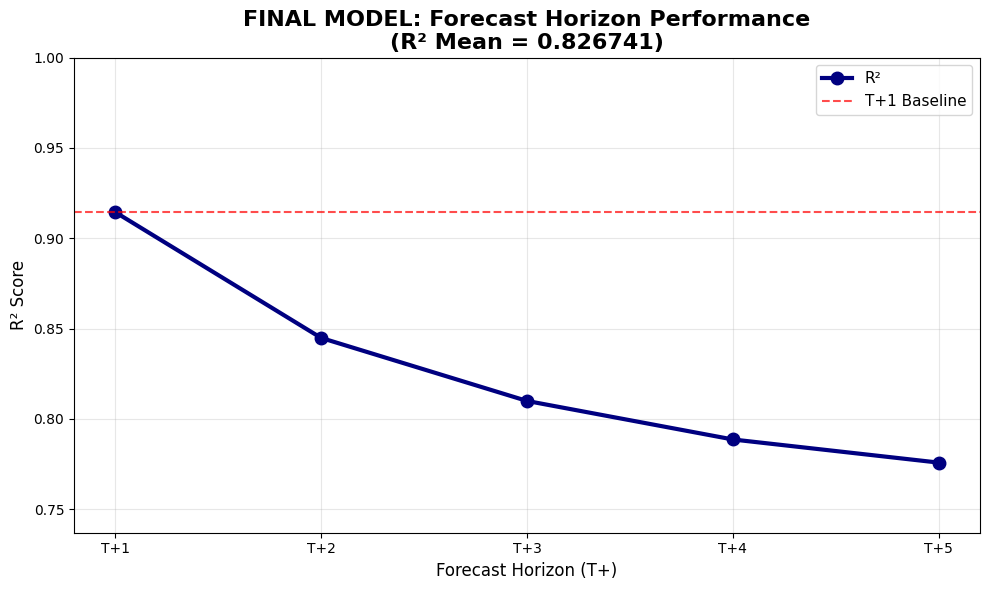

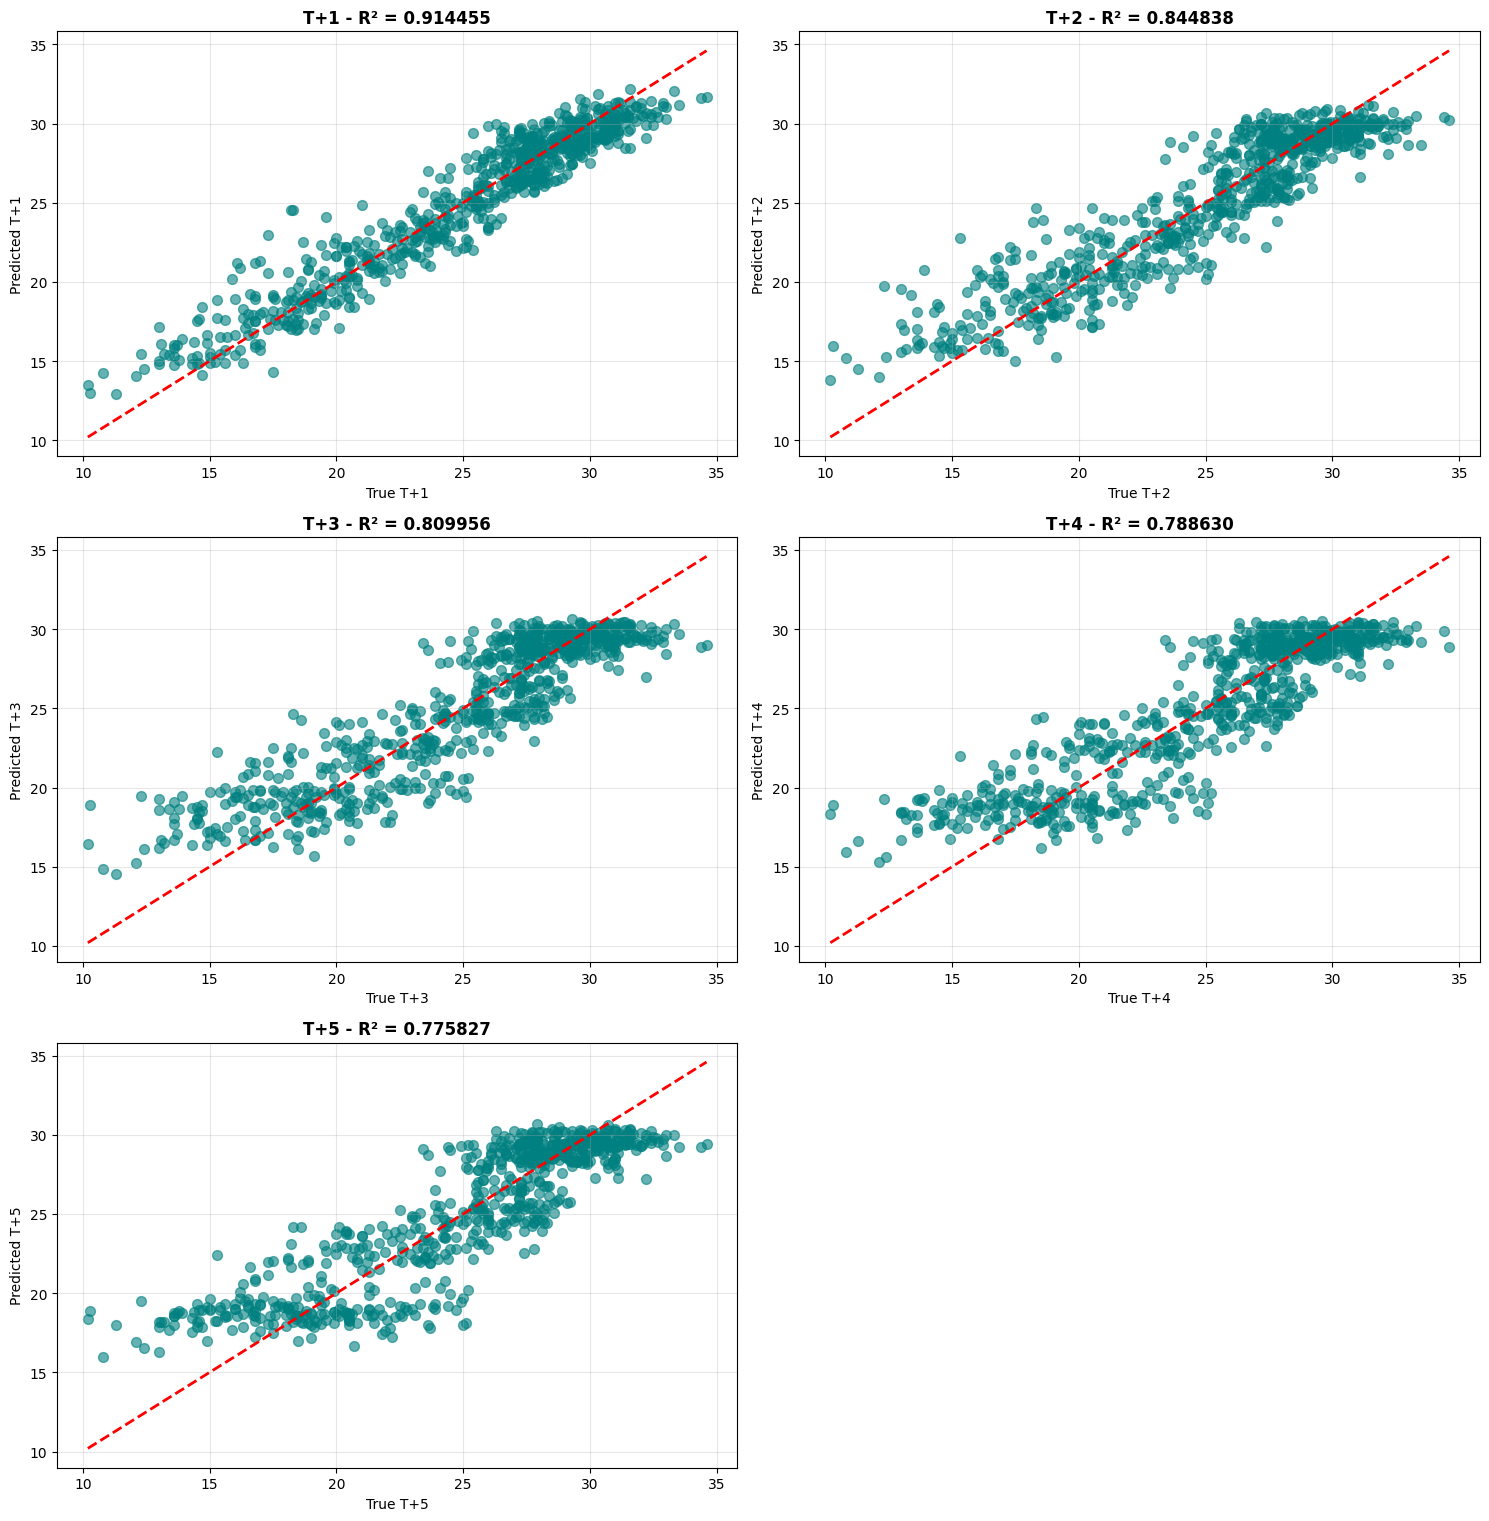

In [ ]:
# === LOAD MODEL ĐÃ TUNING ===
result = joblib.load('../models/daily/BEST_CATBOOST_TUNED_DAILY.joblib')
model = result['model']
best_r2 = result['best_r2']
final_r2_mean = result['final_r2_mean']
target_names = list(result['final_r2_per_target'].keys())[::-1]  # T+1 → T+5

print(f"Model đã load thành công!")
print(f"BEST R² (tuning): {best_r2:.6f}")
print(f"FINAL R² (model): {final_r2_mean:.6f}")

# === DỰ BÁO ===
y_pred = model.predict(X_test)

# === Chuẩn bị y_test ===
y_test_df = pd.DataFrame(y_test).copy()
n_targets = y_test_df.shape[1]
y_test_df = y_test_df.iloc[:, ::-1].copy()
y_test_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
target_names = y_test_df.columns.tolist()[::-1]  # T+1 → T+5

print(f"Dự báo thành công: {y_pred.shape}")

# === Tính metrics ===
r2_list = [r2_score(y_test_df.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
mae_list = [mean_absolute_error(y_test_df.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
rmse_list = [np.sqrt(mean_squared_error(y_test_df.iloc[:, i], y_pred[:, i])) for i in range(n_targets)]
r2_mean = np.mean(r2_list)

# === DEGRADATION ===
degradation_list = [r2_list[i] - r2_list[0] for i in range(1, n_targets)]
degradation_1_to_5 = r2_list[-1] - r2_list[0] if n_targets > 1 else 0

# === IN KẾT QUẢ ===
print("\n" + "="*100)
print(f"{' '*35} FINAL MODEL PERFORMANCE")
print("="*100)
print(f"{'Day':<8} {'R²':>10} {'MAE':>12} {'RMSE':>12} {'ΔR² vs T+1':>15} {'% Change':>12}")
print("-" * 100)
for i, (name, r2, mae, rmse) in enumerate(zip(target_names, r2_list, mae_list, rmse_list)):
    delta = "—" if i == 0 else f"{degradation_list[i-1]:+0.4f}"
    pct = "—" if i == 0 else f"{degradation_list[i-1]/r2_list[0]:+0.2%}"
    print(f"{name:<8} {r2:10.6f} {mae:12.4f} {rmse:12.4f} {delta:>15} {pct:>12}")
print("-" * 100)
print(f"{'MEAN':<8} {r2_mean:10.6f}")
print(f"{'BASELINE':<8} {best_r2:10.6f} ← từ tuning")
print(f"{'MATCH':<8} {abs(r2_mean - best_r2) < 1e-6}")
print("="*100)

plt.figure(figsize=(10, 6))
days = list(range(1, n_targets + 1))
plt.plot(days, r2_list, 'o-', color='navy', linewidth=3, markersize=9, label='R²')
plt.axhline(y=r2_list[0], color='red', linestyle='--', alpha=0.7, label='T+1 Baseline')
plt.title(f'FINAL MODEL: Forecast Horizon Performance\n(R² Mean = {r2_mean:.6f})', fontsize=16, fontweight='bold')
plt.xlabel('Forecast Horizon (T+)', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.xticks(days, [f"T+{d}" for d in days])
plt.ylim(min(r2_list)*0.95, 1.0)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5*n_targets))
for i, target in enumerate(target_names):
    plt.subplot(n_targets, 2, i+1)
    plt.scatter(y_test_df.iloc[:, i], y_pred[:, i], alpha=0.6, s=50, color='teal')
    min_val = min(y_test_df.iloc[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test_df.iloc[:, i].max(), y_pred[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel(f'True {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'{target} - R² = {r2_list[i]:.6f}', fontweight='bold')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
